# Importing all the required libraries

In [1]:
# Import reqired libraries
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import gaussian_kde
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set display width to a high value

# Defining miscellaneous functions

In [2]:
# Function to print colored text
def print_colored(text, color):
    color_codes = {
        'black': '0;30',
        'red': '0;31',
        'green': '0;32',
        'yellow': '0;33',
        'blue': '0;34',
        'purple': '0;35',
        'cyan': '0;36',
        'white': '0;37',
        'bold_black': '1;30',
        'bold_red': '1;31',
        'bold_green': '1;32',
        'bold_yellow': '1;33',
        'bold_blue': '1;34',
        'bold_purple': '1;35',
        'bold_cyan': '1;36',
        'bold_white': '1;37'
    }
    color_code = color_codes.get(color, '0;30')  # Default to white if color not found
    print(f"\033[{color_code}m{text}\033[0m")

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        #'text.latex.preamble' : [r'\usepackage{amsmath}'],
        'mathtext.fontset' : 'stix',
        'mathtext.rm' : 'serif'
}
mpl.rcParams.update(nice_fonts)

# Loading the datasets in pandas DataFrames

In [3]:
# List of assets
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'SPY', 'GLD', 'BTC-USD']

# Create a dictionary to store dataframes for each asset
data = {}

# Loop through each asset to load
for asset in assets:
    # Define the file path
    file_path = f'../data/{asset}_enhanced_data.csv'
    
    # Load the data into a DataFrame
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    data[asset] = df

# Drop the duplicate rows

In [4]:
for asset, df in data.items():
    duplicate_rows_df = df [df.duplicated()]
    #print("Number of duplicate rows: ", duplicate_rows_df.shape)
    #print(df.count())
    df = df.drop_duplicates ()
    data[asset] = df

# Display the first few rows of the DataFrame

In [5]:
for asset, df in data.items():
    print_colored(f"\n{asset} data:", 'blue')
    print(df.head())


AAPL data:
                Open      High       Low     Close  Adj Close     Volume  Daily Return      MA20      MA50     EMA20     EMA50        RSI      MACD  Signal Line  Volatility
Date                                                                                                                                                                        
2010-03-16  8.006429  8.035000  7.946786  8.016071   6.777209  446908000      0.002725  6.395352  6.249025  7.671511  7.506035  90.199387  0.165477     0.078116    0.012642
2010-03-17  8.032143  8.087500  7.973929  8.004286   6.767246  450956800     -0.001470  6.427917  6.255130  7.703204  7.525574  88.698407  0.177630     0.098019    0.012552
2010-03-18  8.003571  8.035714  7.950357  8.023214   6.783248  342109600      0.002365  6.460708  6.261332  7.733681  7.545089  87.806739  0.188592     0.116133    0.012546
2010-03-19  8.028214  8.044286  7.901071  7.937500   6.710782  559445600     -0.010683  6.491779  6.268144  7.753093  7.560

# Basic Data Information

In [6]:
for asset, df in data.items():
  print_colored(f"\n{asset} DataFrame Info:", "blue")
  print(df.info())


AAPL DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3223 entries, 2010-03-16 to 2022-12-30
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3223 non-null   float64
 1   High          3223 non-null   float64
 2   Low           3223 non-null   float64
 3   Close         3223 non-null   float64
 4   Adj Close     3223 non-null   float64
 5   Volume        3223 non-null   int64  
 6   Daily Return  3223 non-null   float64
 7   MA20          3223 non-null   float64
 8   MA50          3223 non-null   float64
 9   EMA20         3223 non-null   float64
 10  EMA50         3223 non-null   float64
 11  RSI           3223 non-null   float64
 12  MACD          3223 non-null   float64
 13  Signal Line   3223 non-null   float64
 14  Volatility    3223 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 402.9 KB
None

MSFT DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Date

# Statistical Information

In [9]:
for asset, df in data.items():
  print_colored(f"\n{asset} Summary Statistics:", "blue")
  print(df.describe())


AAPL Summary Statistics:
              Open         High          Low        Close    Adj Close        Volume  Daily Return         MA20         MA50        EMA20        EMA50          RSI         MACD  Signal Line   Volatility
count  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000  3.223000e+03   3223.000000  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000
mean     51.965384    52.544952    51.392432    51.989255    49.716614  2.502502e+08      0.001079    49.345039    48.707528    51.611389    50.971960    55.773609     0.639429     0.644875     0.016557
std      47.373793    47.985713    46.775815    47.402365    47.495331  2.154475e+08      0.018083    47.279412    46.845073    47.150943    46.687902    17.766159     2.149265     2.077773     0.007340
min       7.873929     8.035000     7.116071     7.937500     6.710782  3.519590e+07     -0.128647     6.395352     6.249025     7.671511     7.506035     3.14279

# Check for missing values and NaN

In [10]:
for asset, df in data.items():
  print_colored(f"\n{asset} Missing Values:", "blue")
  print(df.isnull().sum())


AAPL Missing Values:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily Return    0
MA20            0
MA50            0
EMA20           0
EMA50           0
RSI             0
MACD            0
Signal Line     0
Volatility      0
dtype: int64

MSFT Missing Values:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily Return    0
MA20            0
MA50            0
EMA20           0
EMA50           0
RSI             0
MACD            0
Signal Line     0
Volatility      0
dtype: int64

GOOGL Missing Values:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily Return    0
MA20            0
MA50            0
EMA20           0
EMA50           0
RSI             0
MACD            0
Signal Line     0
Volatility      0
dtype: int64

AMZN Missing Values:
Open            0
High            0
Low             0
Close   

In [28]:
# Function to perform EDA for a given asset
def perform_eda(asset, df):
    print_colored(f"--- Analysis for {asset} ---", "blue")
    
    # Decompose the time series for trend analysis
    decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create a PDF file to save the plots
    with PdfPages(f'../plots/{asset}_analysis.pdf') as pdf:
    
        # Create a large plot with subplots for various analyses
        fig, axes = plt.subplots(7, 2, figsize=(18, 28), sharex=False)
        #fig.suptitle(f'Analysis for {asset}', fontsize=16)
        
        # Time series of closing price
        axes[0, 0].plot(df.index, df['Close'], label='Close Price')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].legend()
        axes[0, 0].set_xlim(df.index.min(), df.index.max())
        axes[0, 0].set_ylim(df['Close'].min(), df['Close'].max())
        
        # Time series of volume
        axes[0, 1].plot(df.index, df['Volume'], label='Volume', color='orange')
        axes[0, 1].set_ylabel('Volume')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].legend()
        axes[0, 1].set_xlim(df.index.min(), df.index.max())
        axes[0, 1].set_ylim(df['Volume'].min(), df['Volume'].max())
        
        # Time series of moving averages
        axes[1, 0].plot(df.index, df['MA20'], label='MA20', color='green')
        axes[1, 0].plot(df.index, df['MA50'], label='MA50', color='red')
        axes[1, 0].set_ylabel('Moving Averages')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].legend()
        axes[1, 0].set_xlim(df.index.min(), df.index.max())
        axes[1, 0].set_ylim(min(df['MA20'].min(), df['MA50'].min()), max(df['MA20'].max(), df['MA50'].max()))
        
        # Time series of exponential moving averages
        axes[1, 1].plot(df.index, df['EMA20'], label='EMA20', color='blue')
        axes[1, 1].plot(df.index, df['EMA50'], label='EMA50', color='purple')
        axes[1, 1].set_ylabel('Exponential Moving Averages')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].legend()
        axes[1, 1].set_xlim(df.index.min(), df.index.max())
        axes[1, 1].set_ylim(min(df['EMA20'].min(), df['EMA50'].min()), max(df['EMA20'].max(), df['EMA50'].max()))
        
        # Time series of volatility
        axes[2, 0].plot(df.index, df['Volatility'], label='Volatility', color='purple')
        axes[2, 0].set_ylabel('Volatility')
        axes[2, 0].set_xlabel('Year')
        axes[2, 0].legend()
        axes[2, 0].set_xlim(df.index.min(), df.index.max())
        axes[2, 0].set_ylim(df['Volatility'].min(), df['Volatility'].max())
        
        # Time series of RSI
        axes[2, 1].plot(df.index, df['RSI'], label='RSI', color='brown')
        axes[2, 1].set_ylabel('RSI')
        axes[2, 1].set_xlabel('Year')
        axes[2, 1].legend()
        axes[2, 1].set_xlim(df.index.min(), df.index.max())
        axes[2, 1].set_ylim(0, 100)
        
        # MACD and Signal Line
        axes[3, 0].plot(df.index, df['MACD'], label='MACD', color='blue')
        axes[3, 0].plot(df.index, df['Signal Line'], label='Signal Line', color='red')
        axes[3, 0].set_ylabel('MACD')
        axes[3, 0].set_xlabel('Year')
        axes[3, 0].legend()
        axes[3, 0].set_xlim(df.index.min(), df.index.max())
        
        # Daily return distribution
        data = df['Daily Return']
        n, bins, patches = axes[3, 1].hist(data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', label='Daily Returns Distribution')
        kde = gaussian_kde(data)
        x = np.linspace(data.min(), data.max(), 1000)
        axes[3, 1].plot(x, kde(x), color='blue', linestyle='--', label='KDE')
        axes[3, 1].legend()
        axes[3, 1].set_xlabel('Daily Return')
        axes[3, 1].set_ylabel('Frequency')
        axes[3, 1].set_xlim(data.min(), data.max())
        
        # Cumulative daily return
        axes[4, 0].plot(df.index, df['Daily Return'].cumsum(), label='Cumulative Daily Return')
        axes[4, 0].set_xlabel('Year')
        axes[4, 0].set_ylabel('Cumulative Return')
        axes[4, 0].legend()
        axes[4, 0].set_xlim(df.index.min(), df.index.max())
        axes[4, 0].set_ylim(df['Daily Return'].cumsum().min(), df['Daily Return'].cumsum().max())
        
        # Trend analysis observed
        axes[4, 1].plot(df.index, df['Close'], label='Observed')
        axes[4, 1].set_xlabel('Year')
        axes[4, 1].set_ylabel('Price')
        axes[4, 1].legend()
        axes[4, 1].set_xlim(df.index.min(), df.index.max())
        axes[4, 1].set_ylim(df['Close'].min(), df['Close'].max())
        
        # Trend analysis
        axes[5, 0].plot(df.index, trend, label='Trend')
        axes[5, 0].set_xlabel('Year')
        axes[5, 0].set_ylabel('Price')
        axes[5, 0].legend()
        axes[5, 0].set_xlim(df.index.min(), df.index.max())
        axes[5, 0].set_ylim(trend.min(), trend.max())
        
        # Trend analysis seasonal
        axes[5, 1].plot(df.index, seasonal, label='Seasonal')
        axes[5, 1].set_xlabel('Year')
        axes[5, 1].set_ylabel('Price')
        axes[5, 1].legend()
        axes[5, 1].set_xlim(df.index.min(), df.index.max())
        axes[5, 1].set_ylim(seasonal.min(), seasonal.max())
        
        # Trend analysis residual
        axes[6, 0].plot(df.index, residual, label='Residual')
        axes[6, 0].set_xlabel('Year')
        axes[6, 0].set_ylabel('Price')
        axes[6, 0].legend()
        axes[6, 0].set_xlim(df.index.min(), df.index.max())
        axes[6, 0].set_ylim(residual.min(), residual.max())
        
        # Daily return time series
        axes[6, 1].plot(df.index, df['Daily Return'], label='Daily Return', color='blue')
        axes[6, 1].set_ylabel('Daily Return')
        axes[6, 1].set_xlabel('Year')
        axes[6, 1].legend()
        axes[6, 1].set_xlim(df.index.min(), df.index.max())
        axes[6, 1].set_ylim(df['Daily Return'].min(), df['Daily Return'].max())

        fig.subplots_adjust(left=0.04,
                    bottom=0.02, 
                    right=0.98, 
                    top=0.99, 
                    wspace=0.2, 
                    hspace=0.3)

        # Save the figure to the PDF and show it
        pdf.savefig(fig)
        plt.show()
        plt.close(fig)

        # Correlation matrix
        fig_corr, ax_corr = plt.subplots(figsize=(10, 6))
        corr = df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax_corr, annot_kws={"size": 10})
        ax_corr.set_title('Correlation Matrix')
        ax_corr.set_aspect(aspect='equal', adjustable='box')
        fig_corr.tight_layout()
        
        # Save the figure to the PDF and show it
        pdf.savefig(fig_corr)
        plt.show()
        plt.close(fig_corr)


--- Analysis for AAPL ---


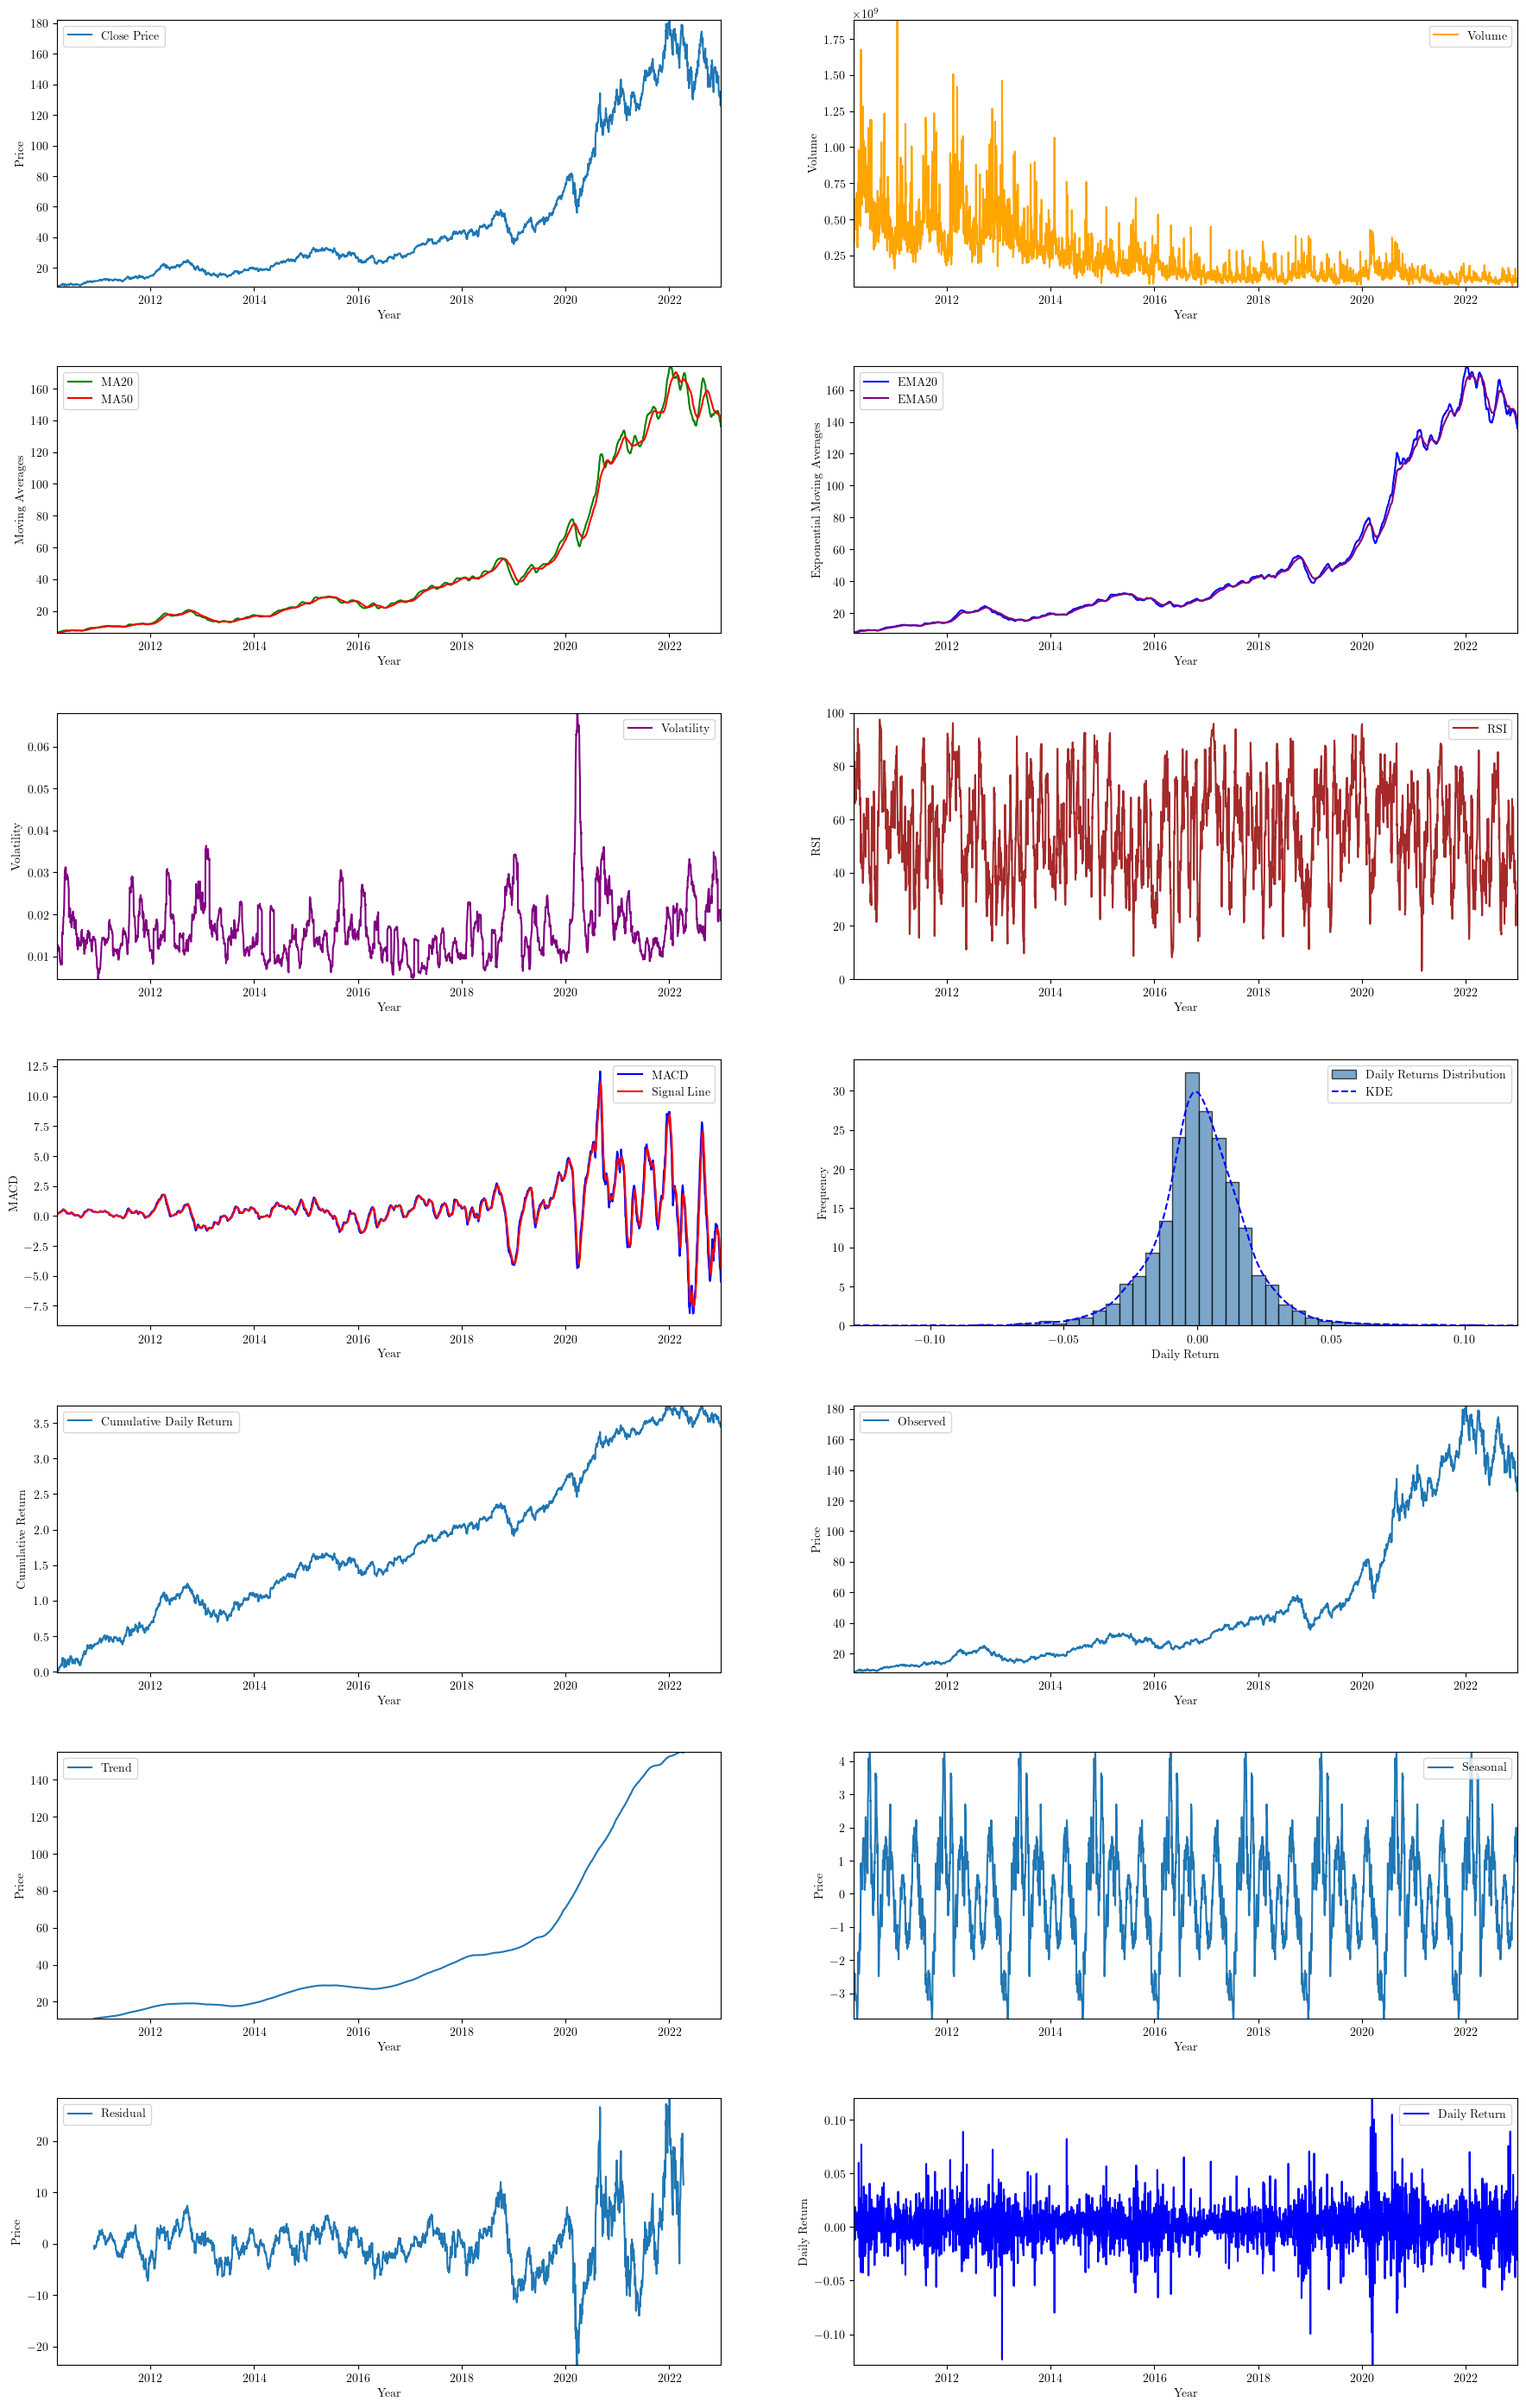

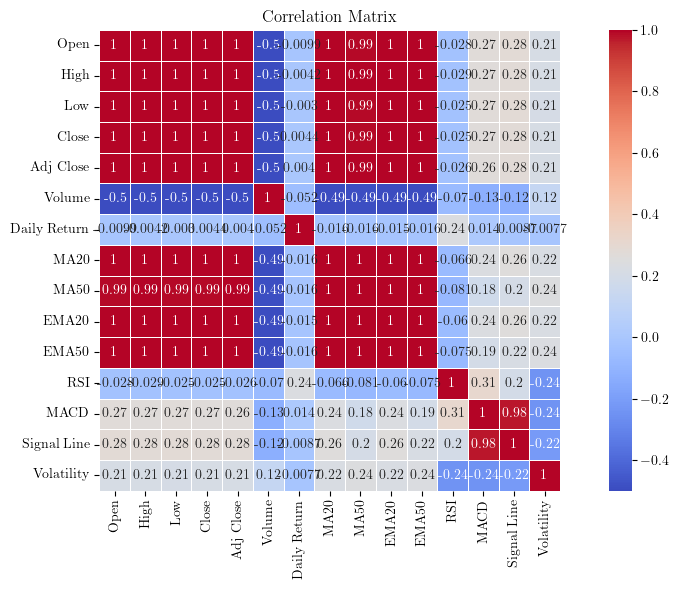

--- Analysis for MSFT ---


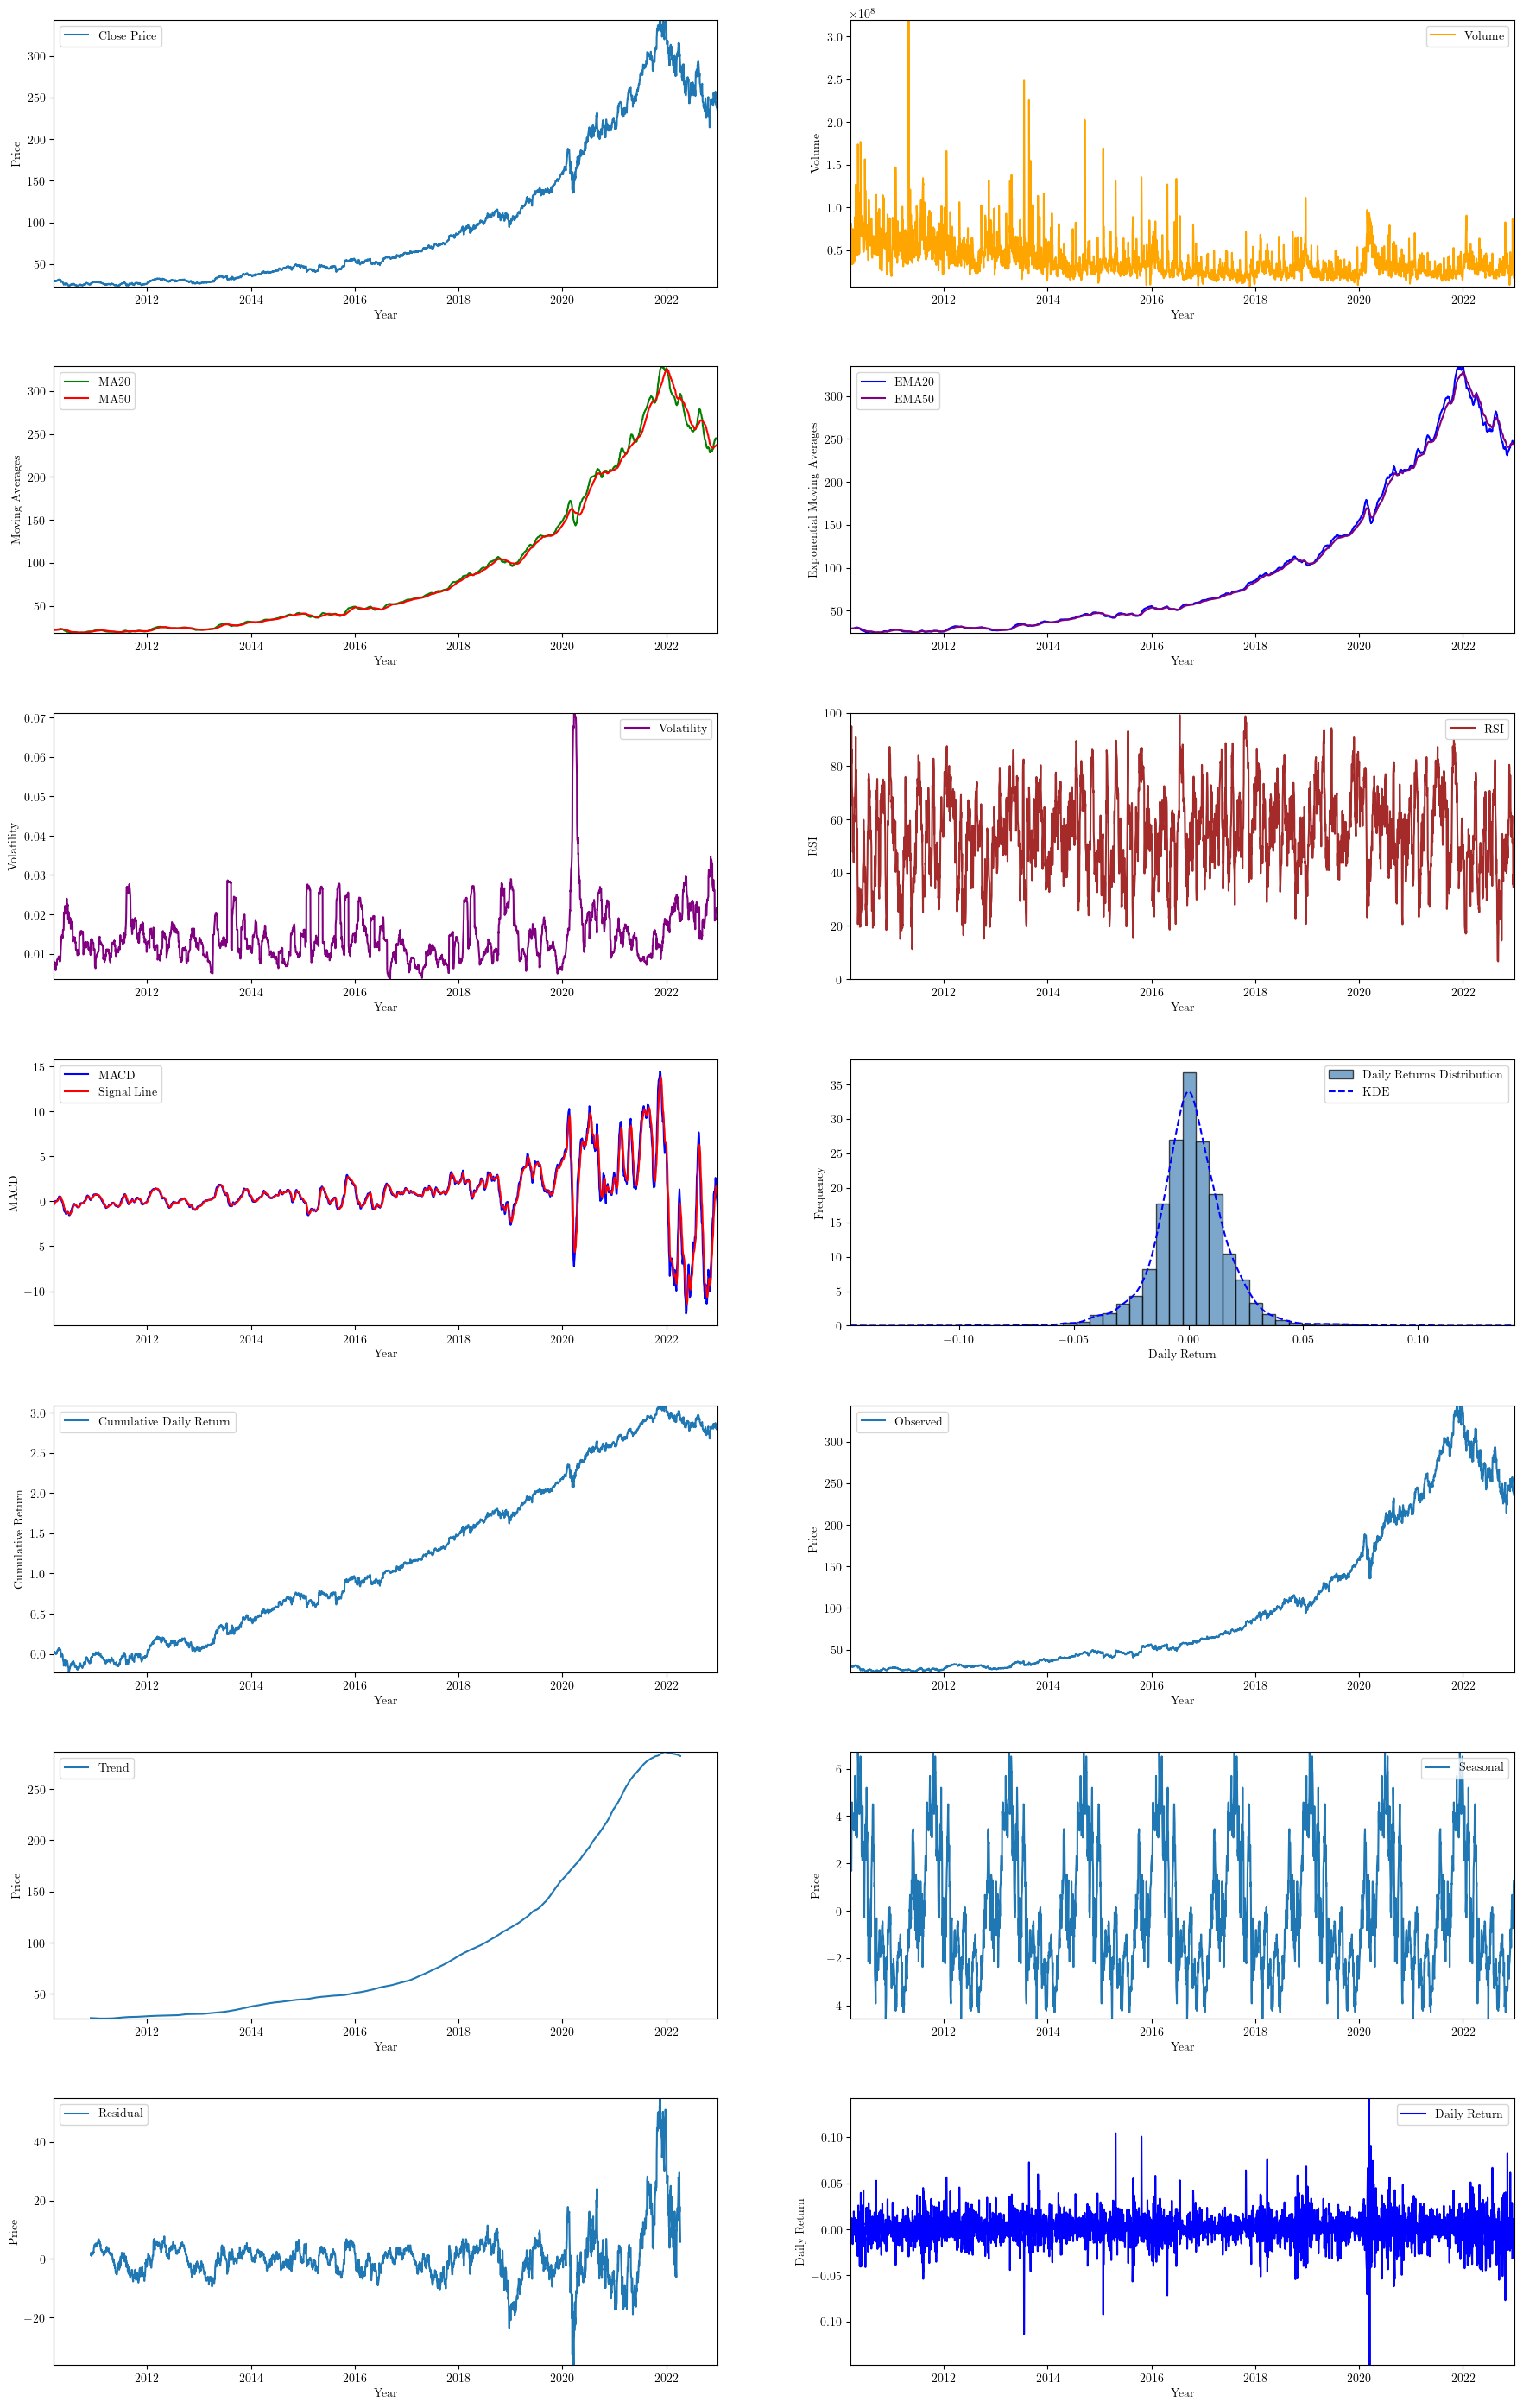

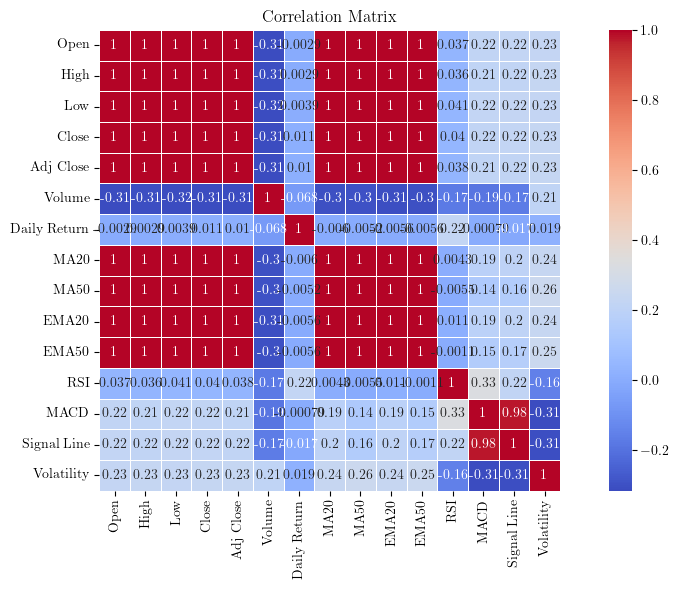

--- Analysis for GOOGL ---


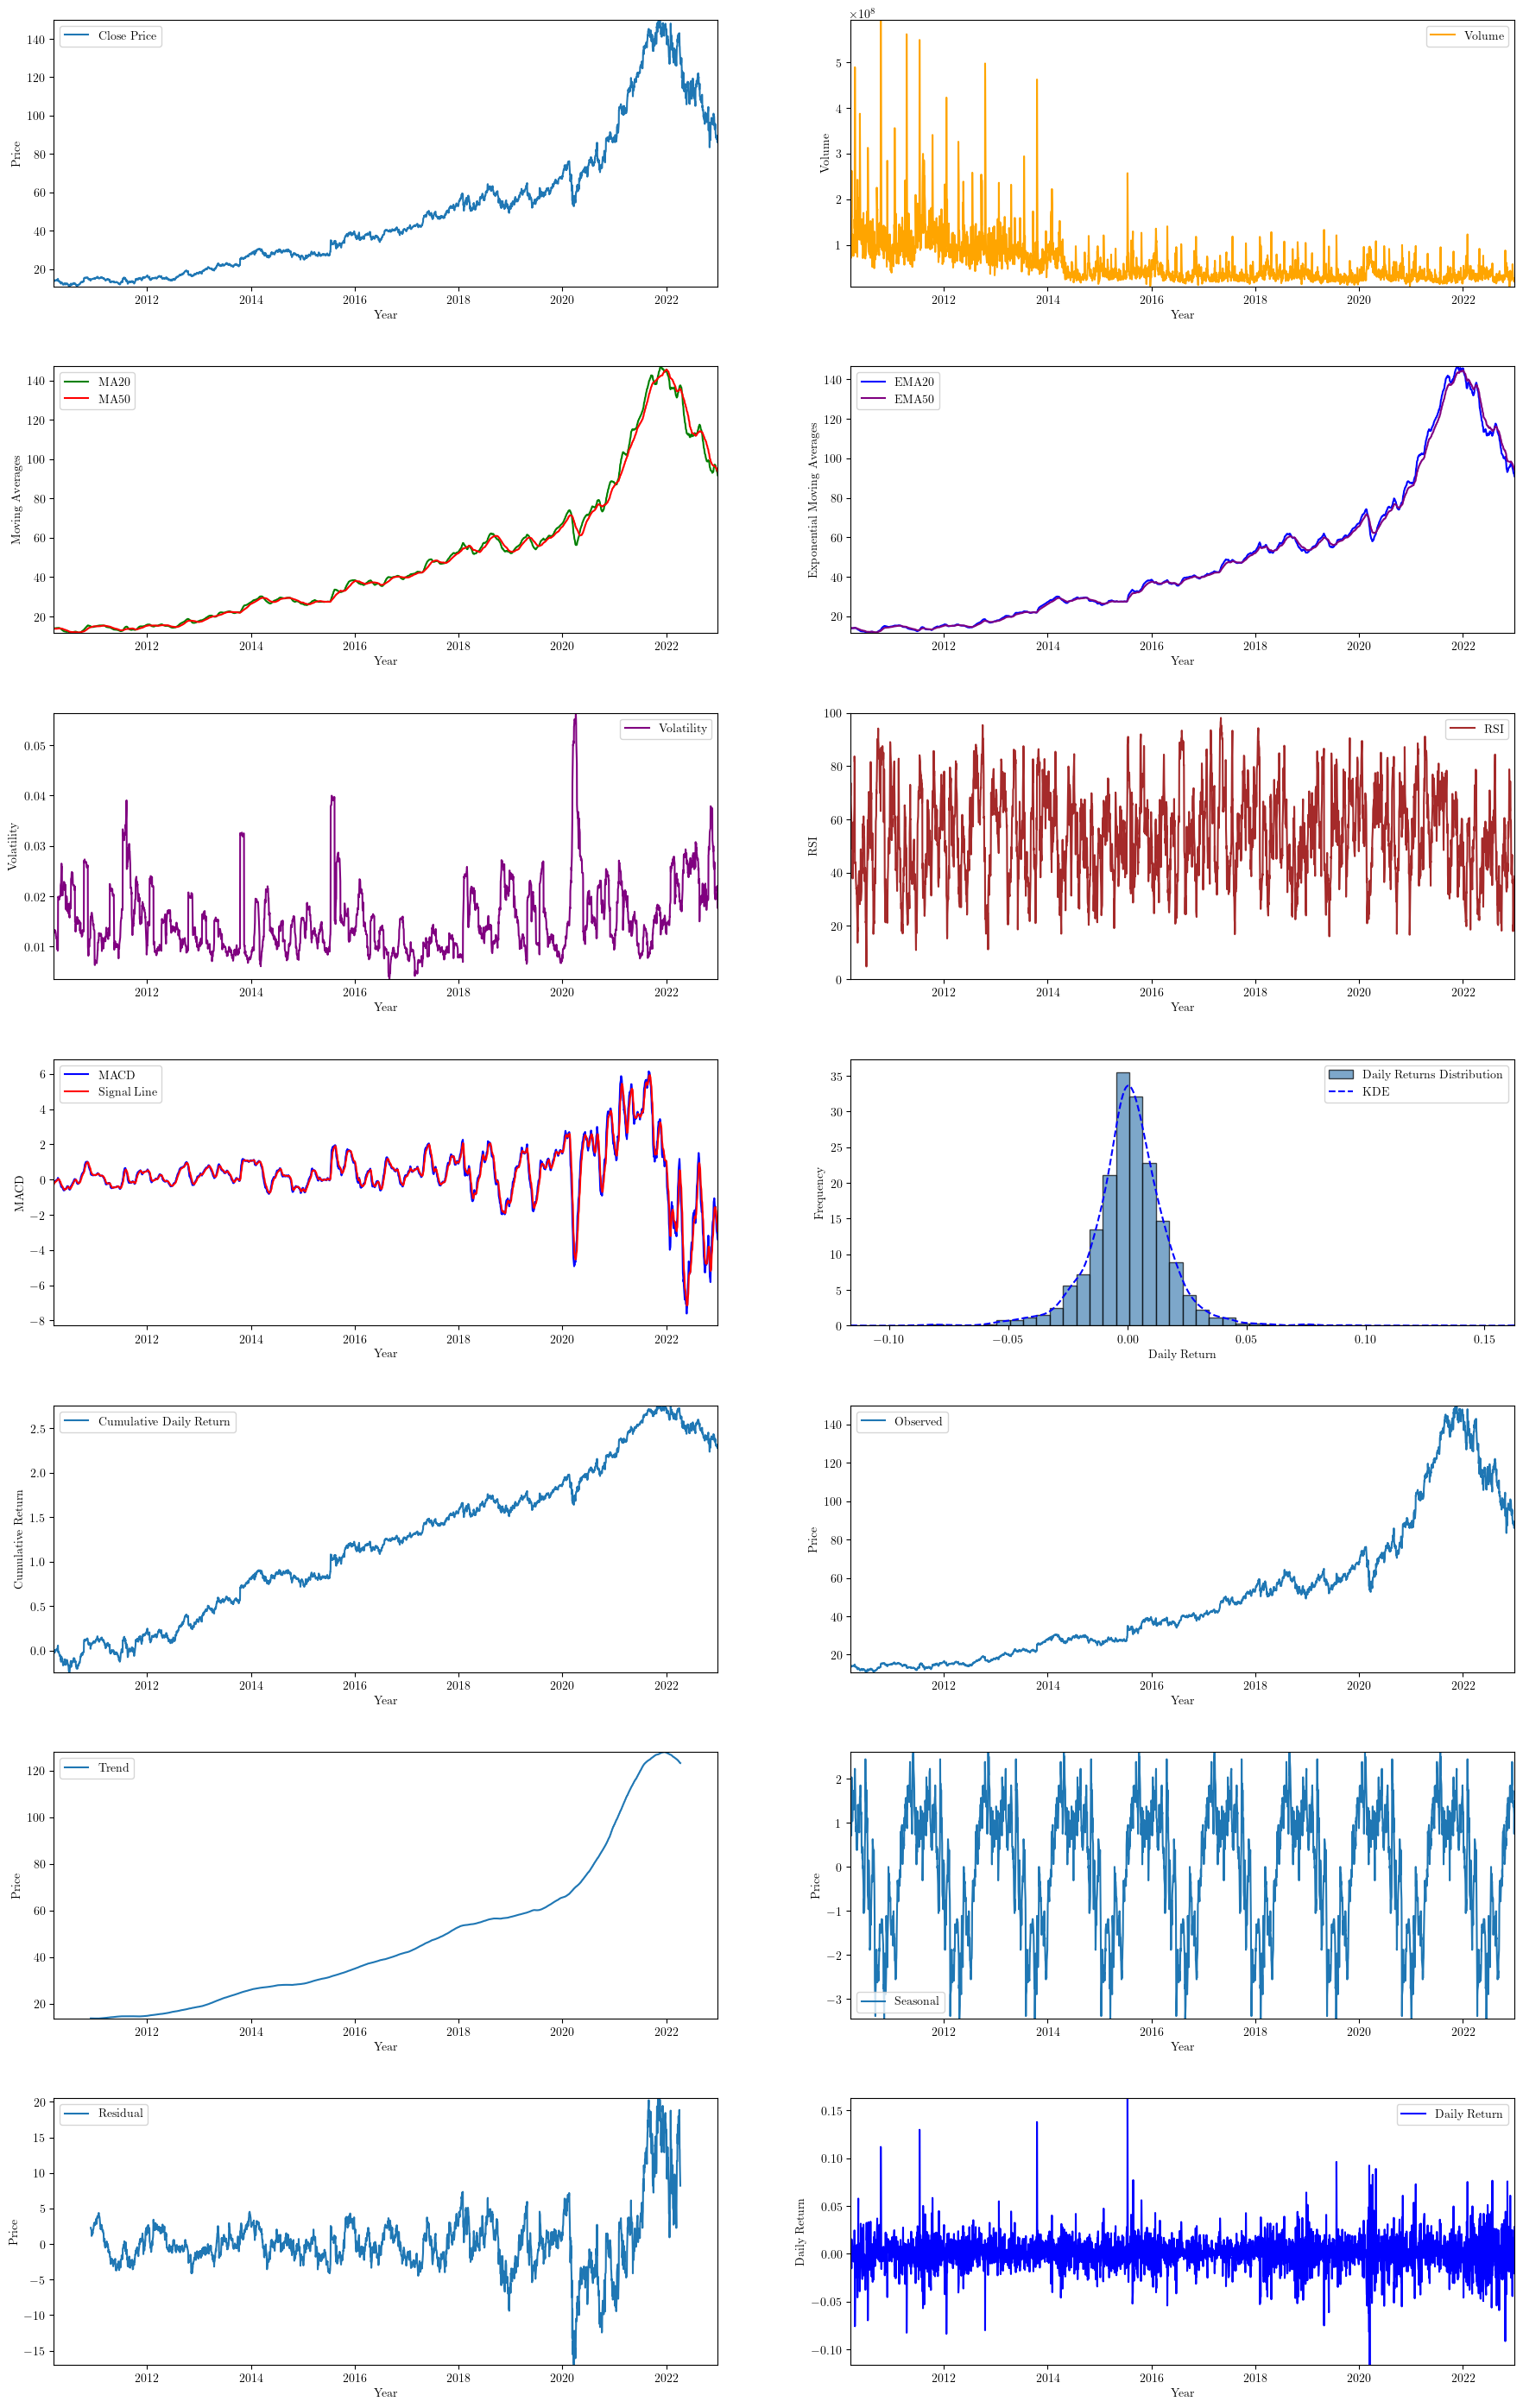

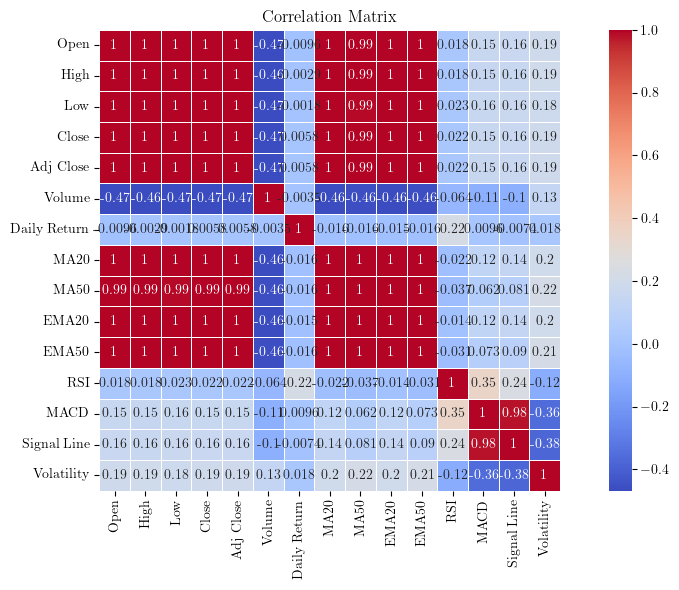

--- Analysis for AMZN ---


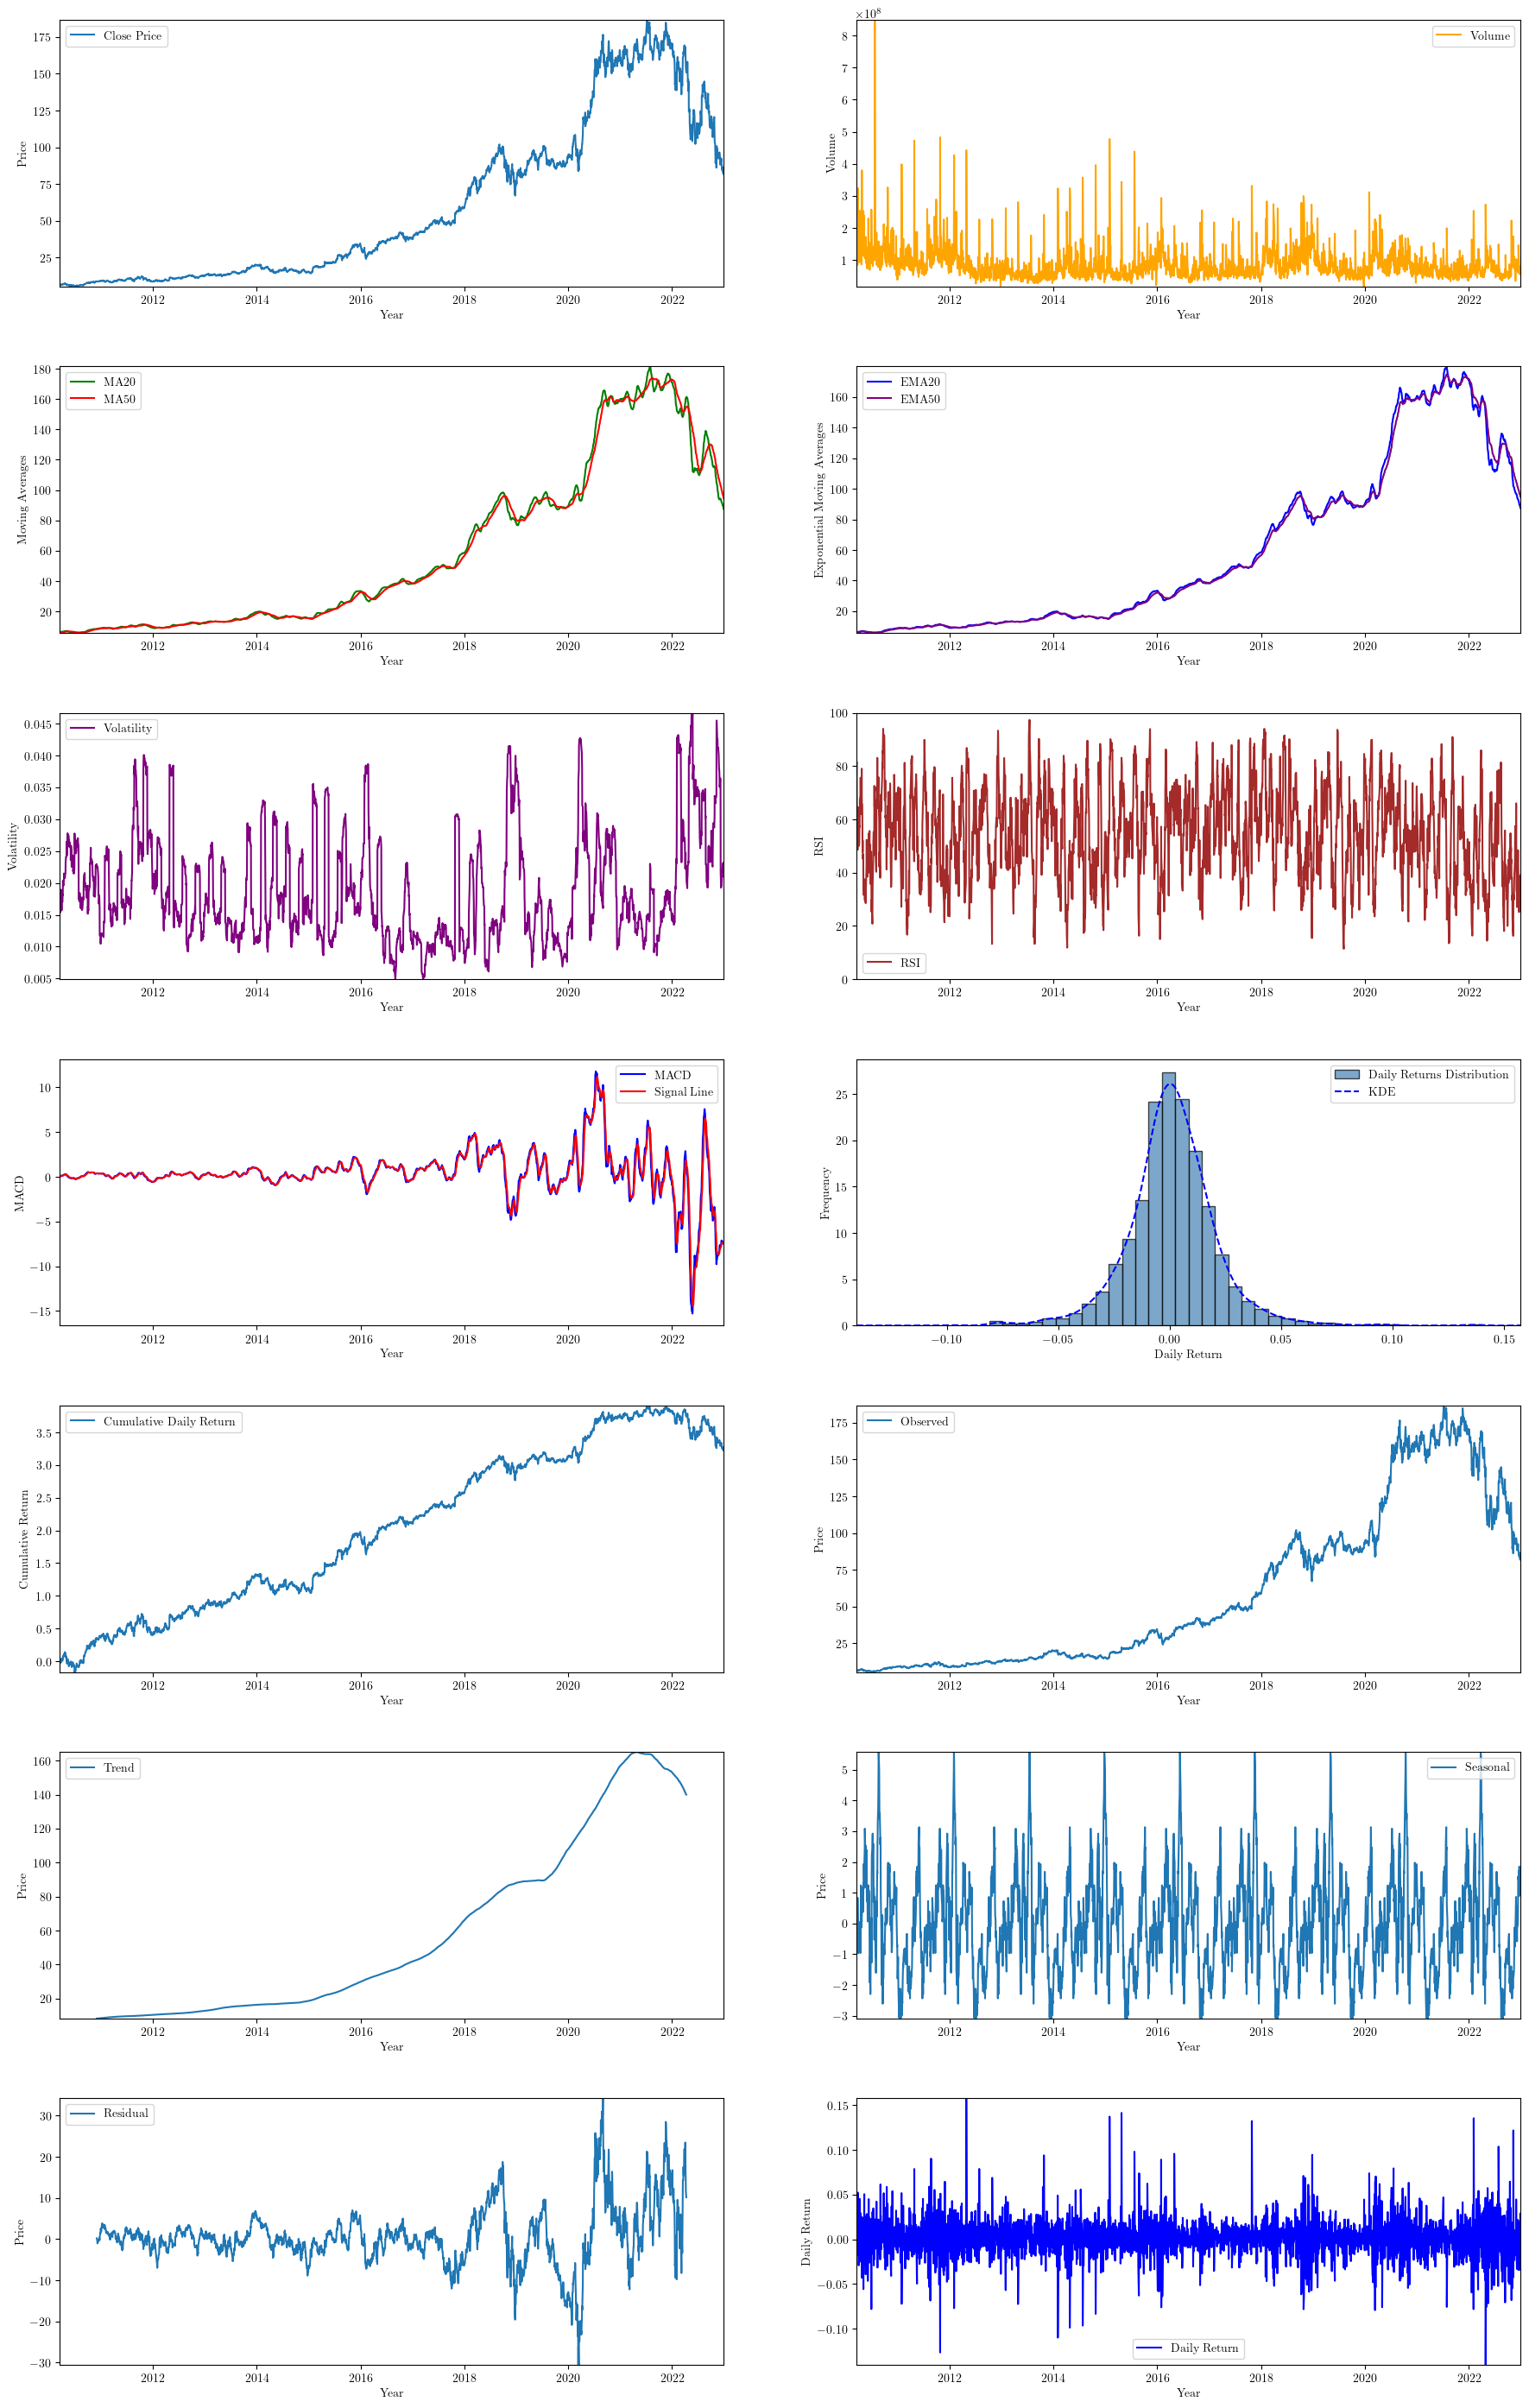

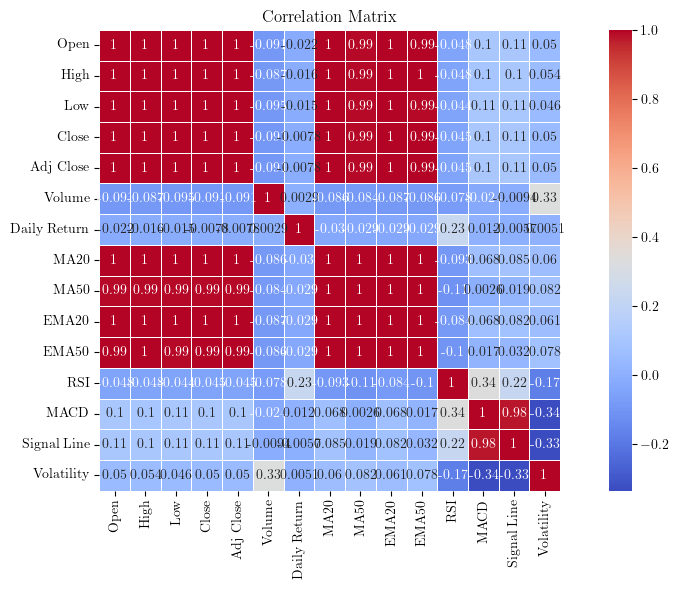

--- Analysis for TSLA ---


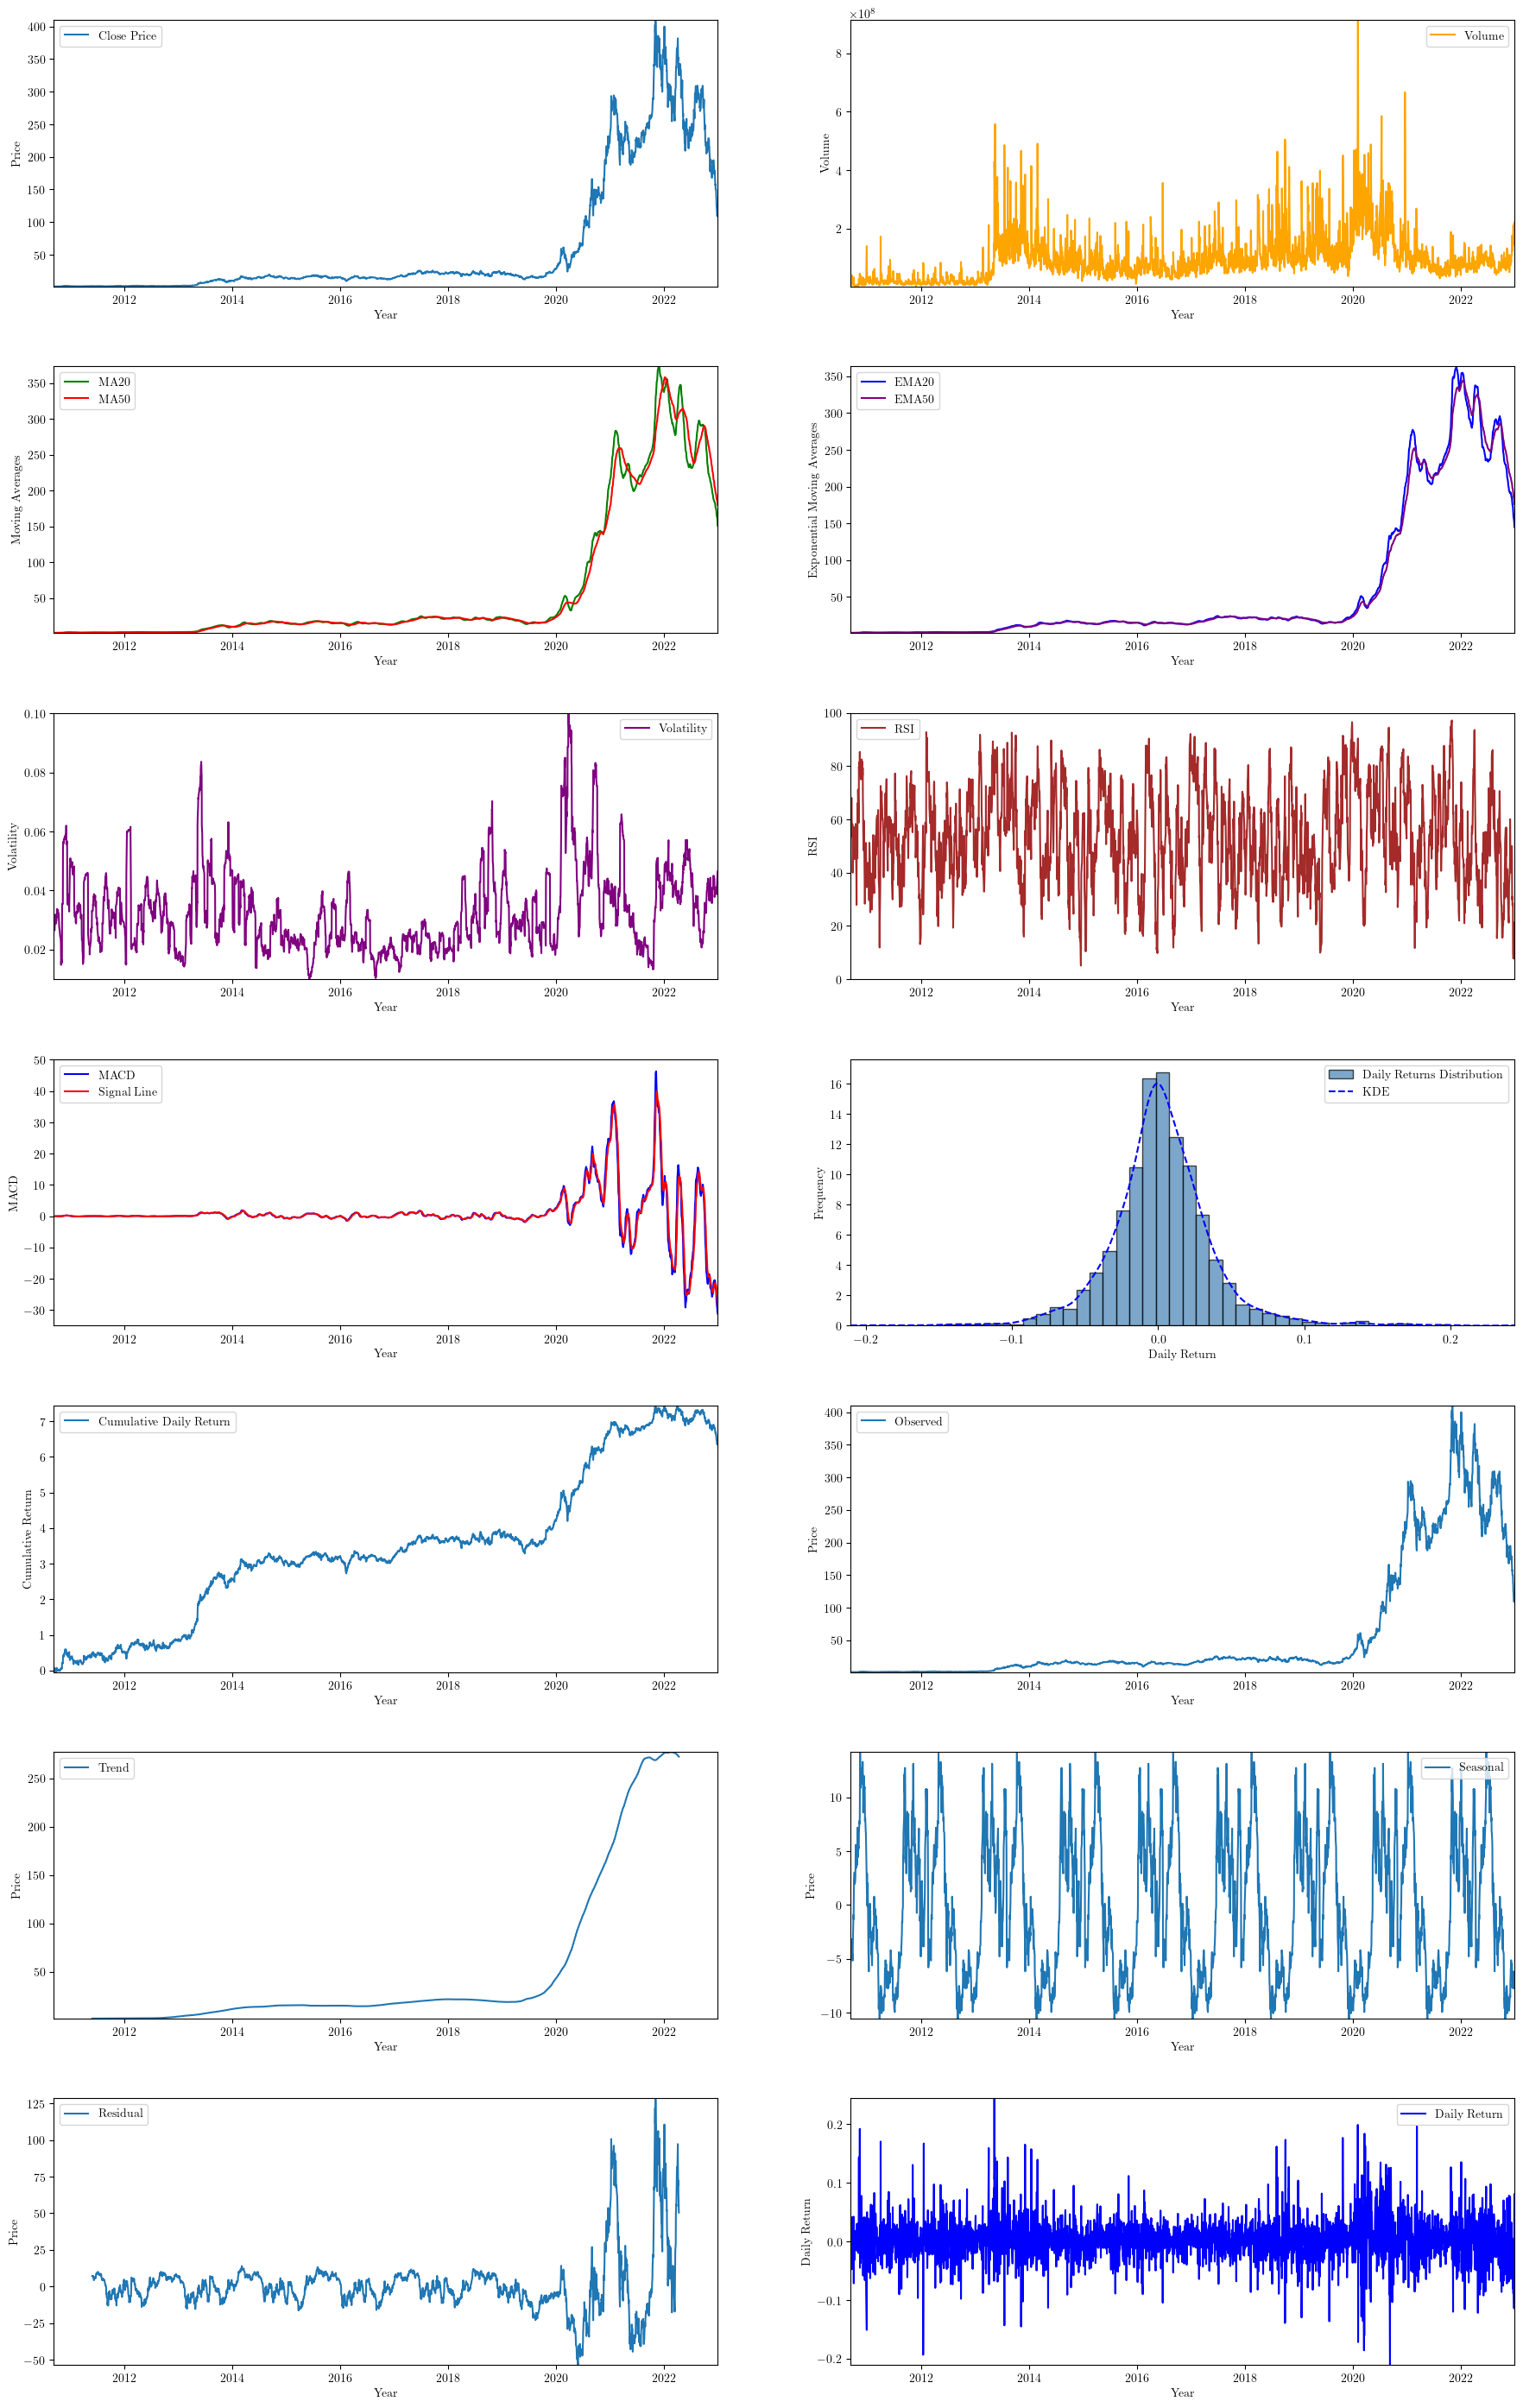

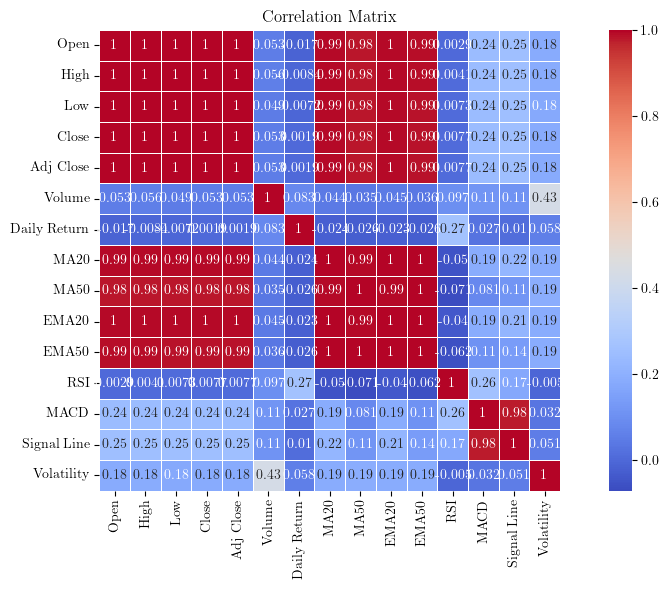

--- Analysis for SPY ---


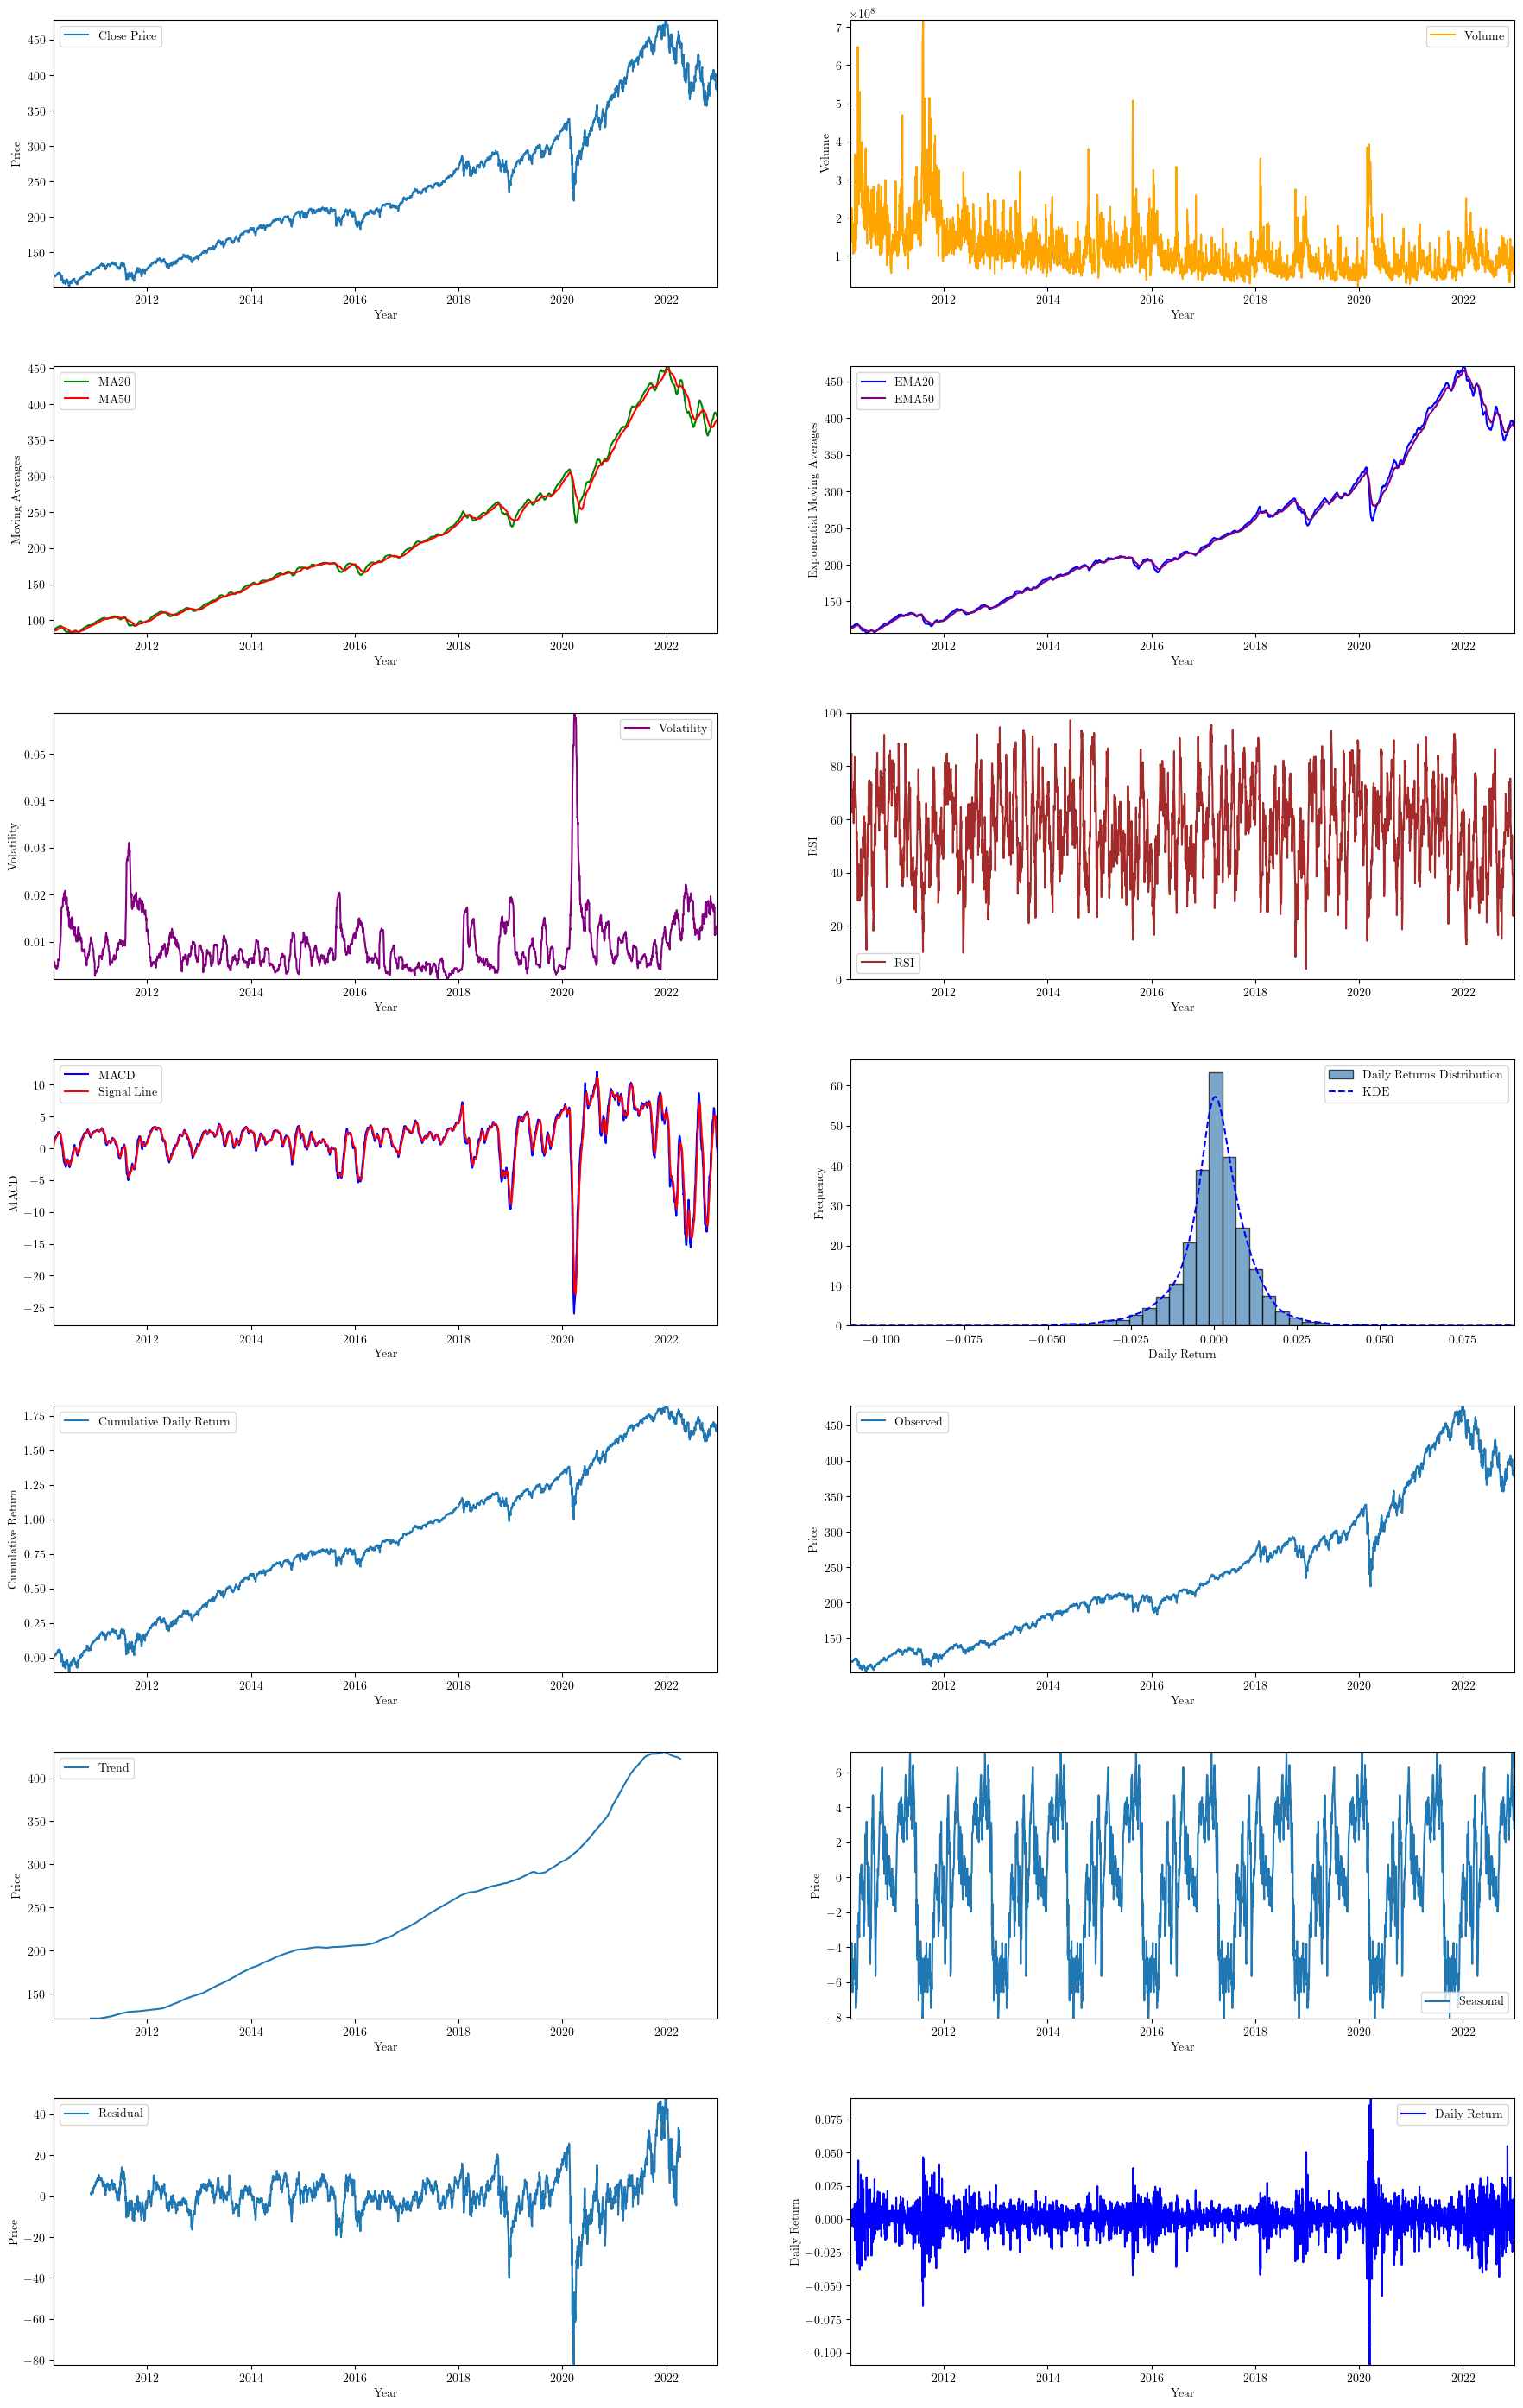

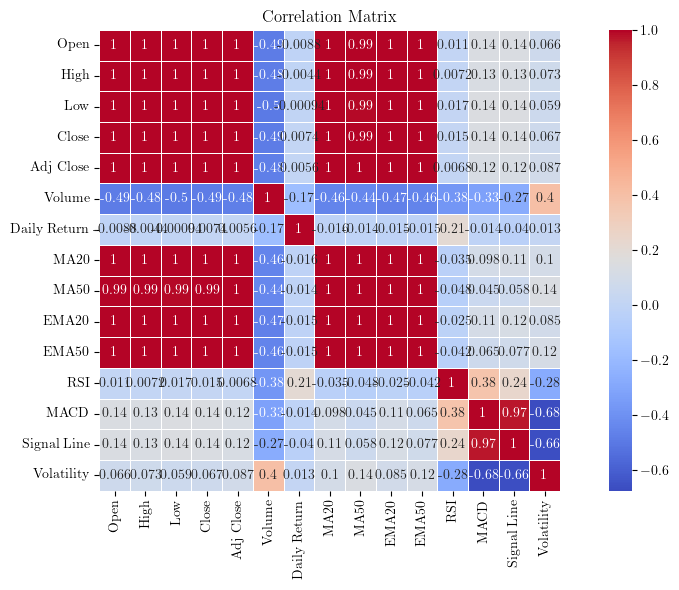

--- Analysis for GLD ---


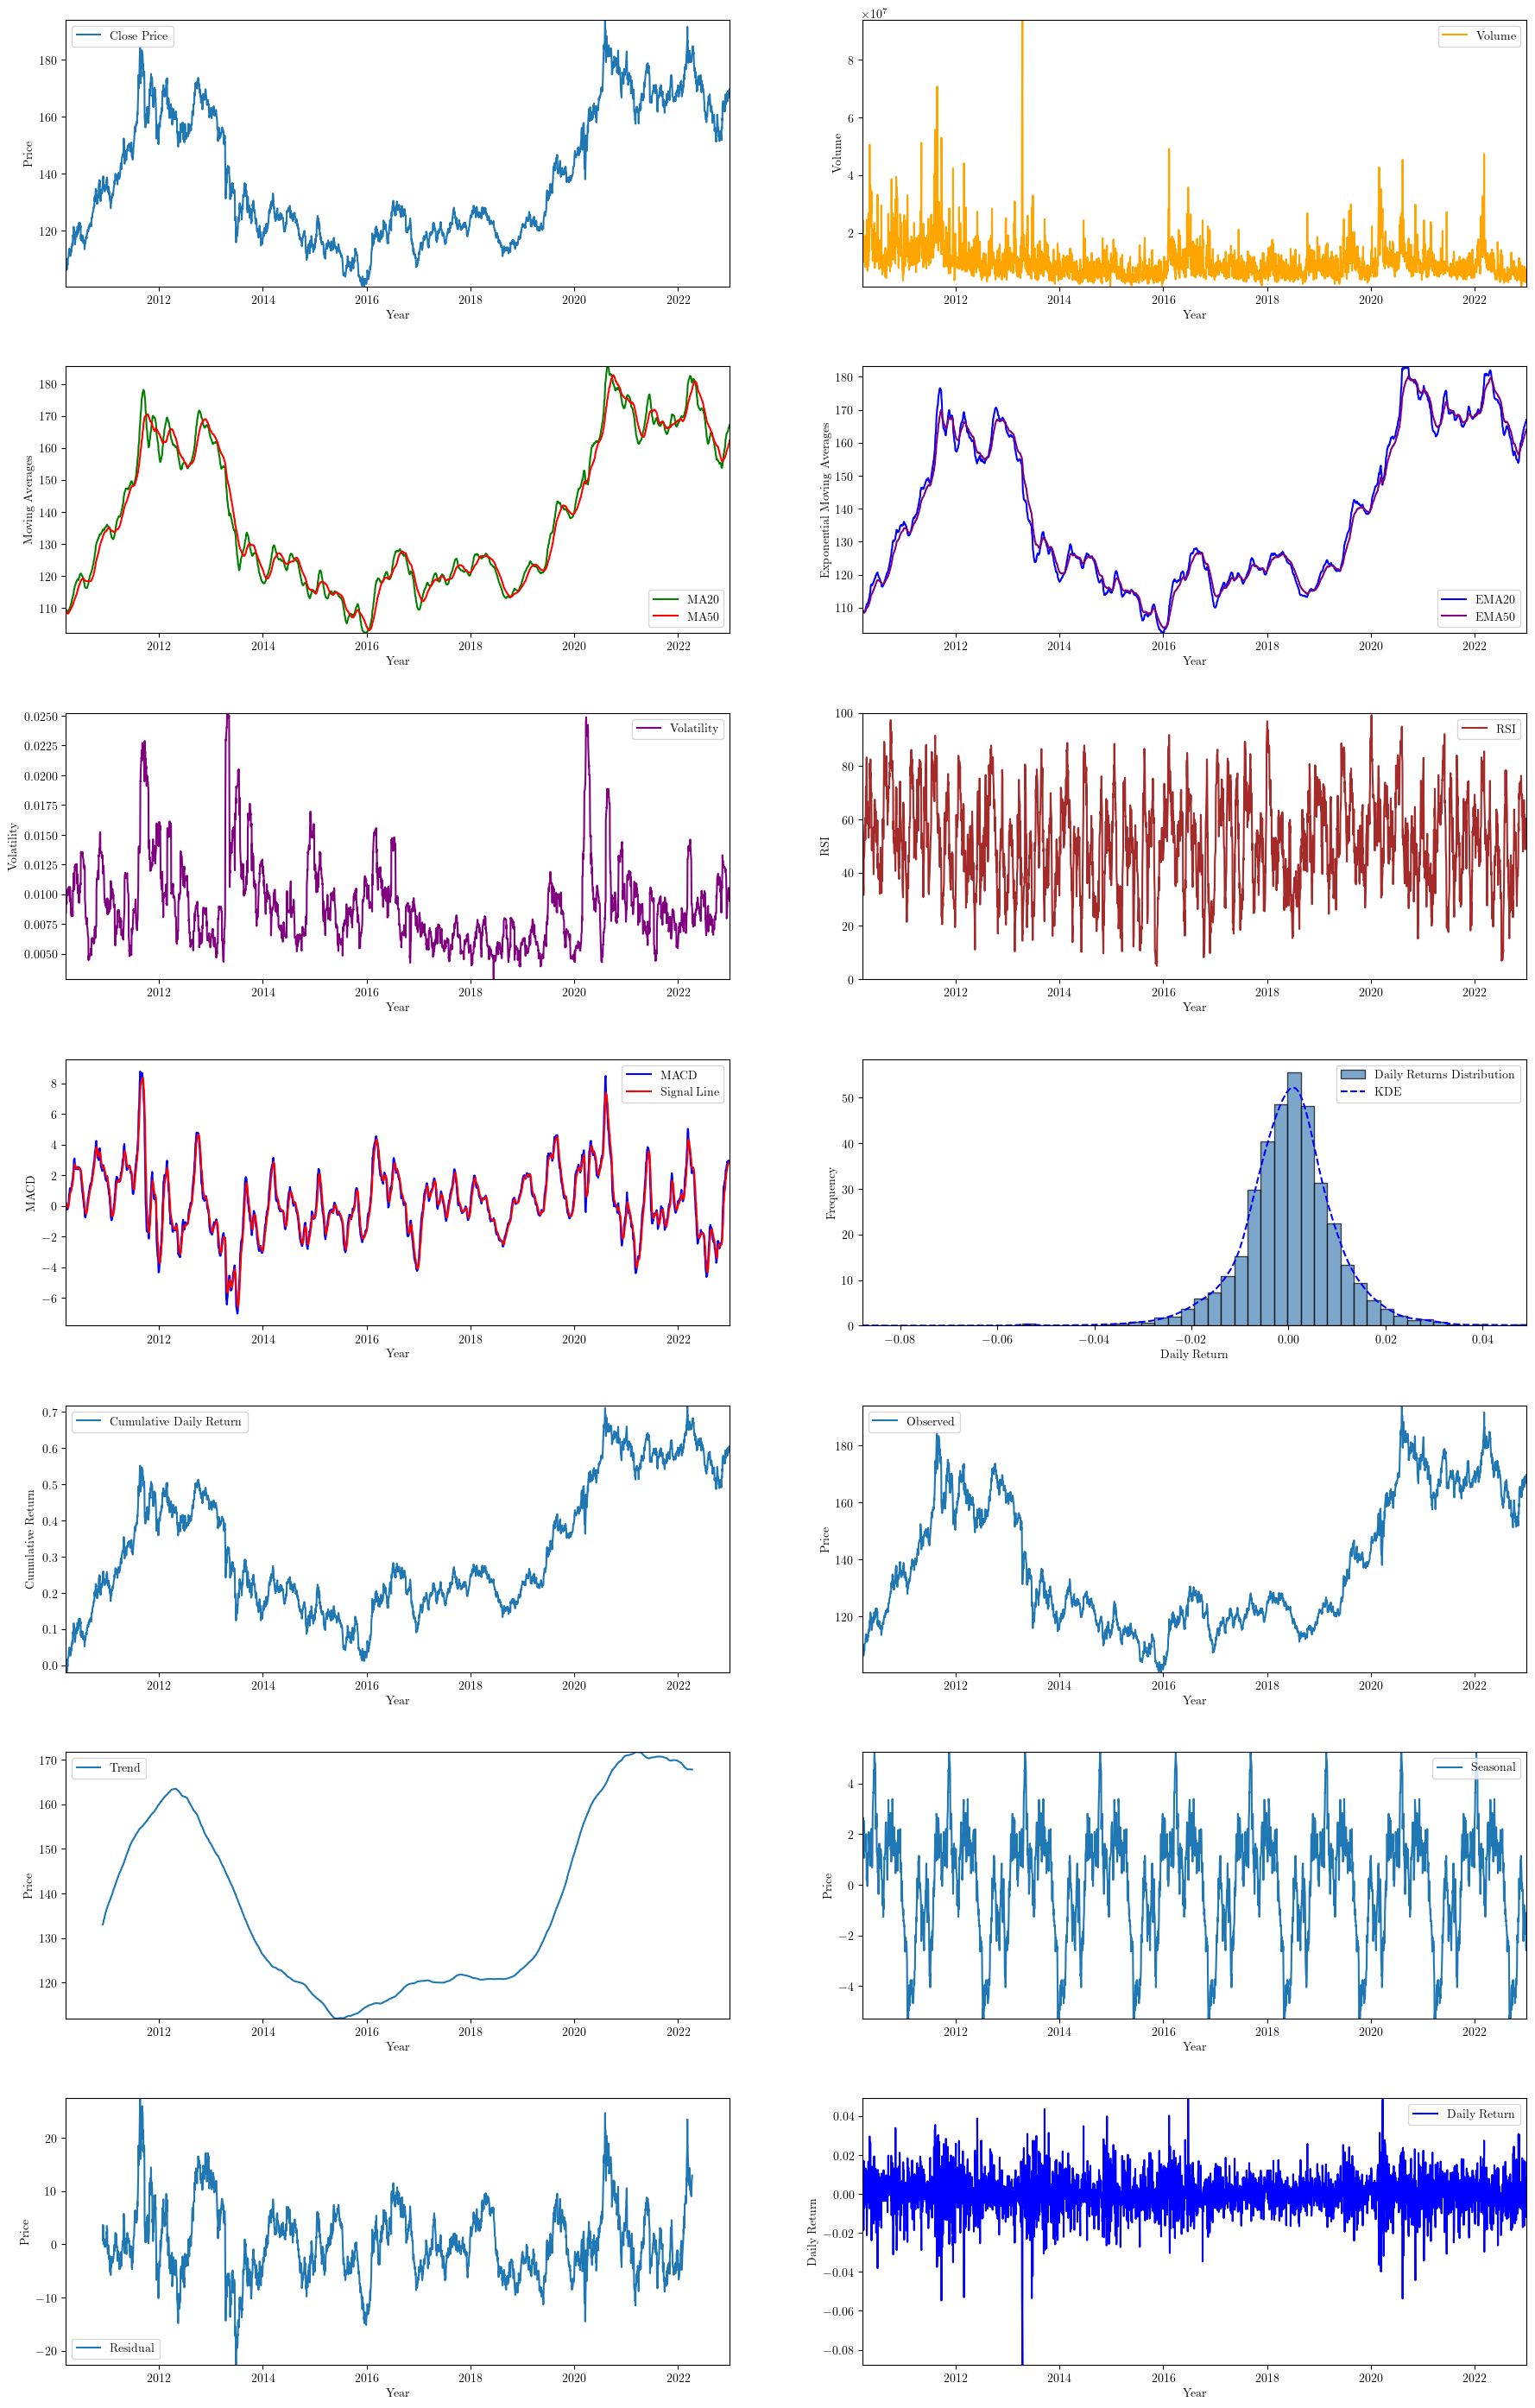

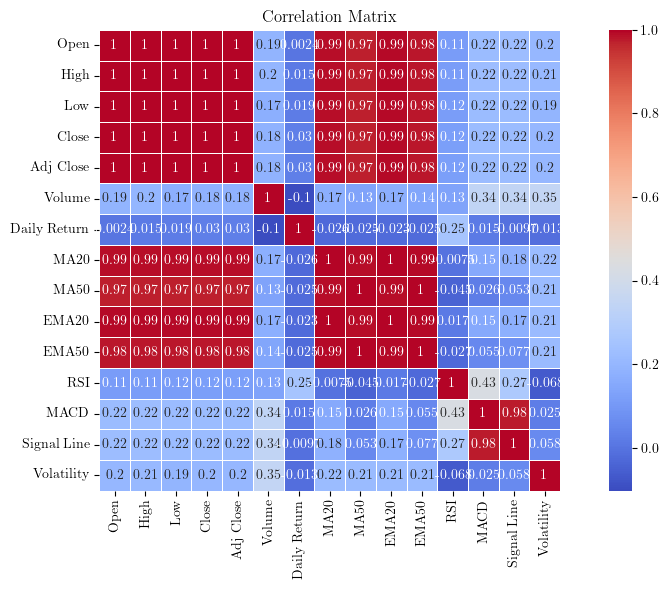

--- Analysis for BTC-USD ---


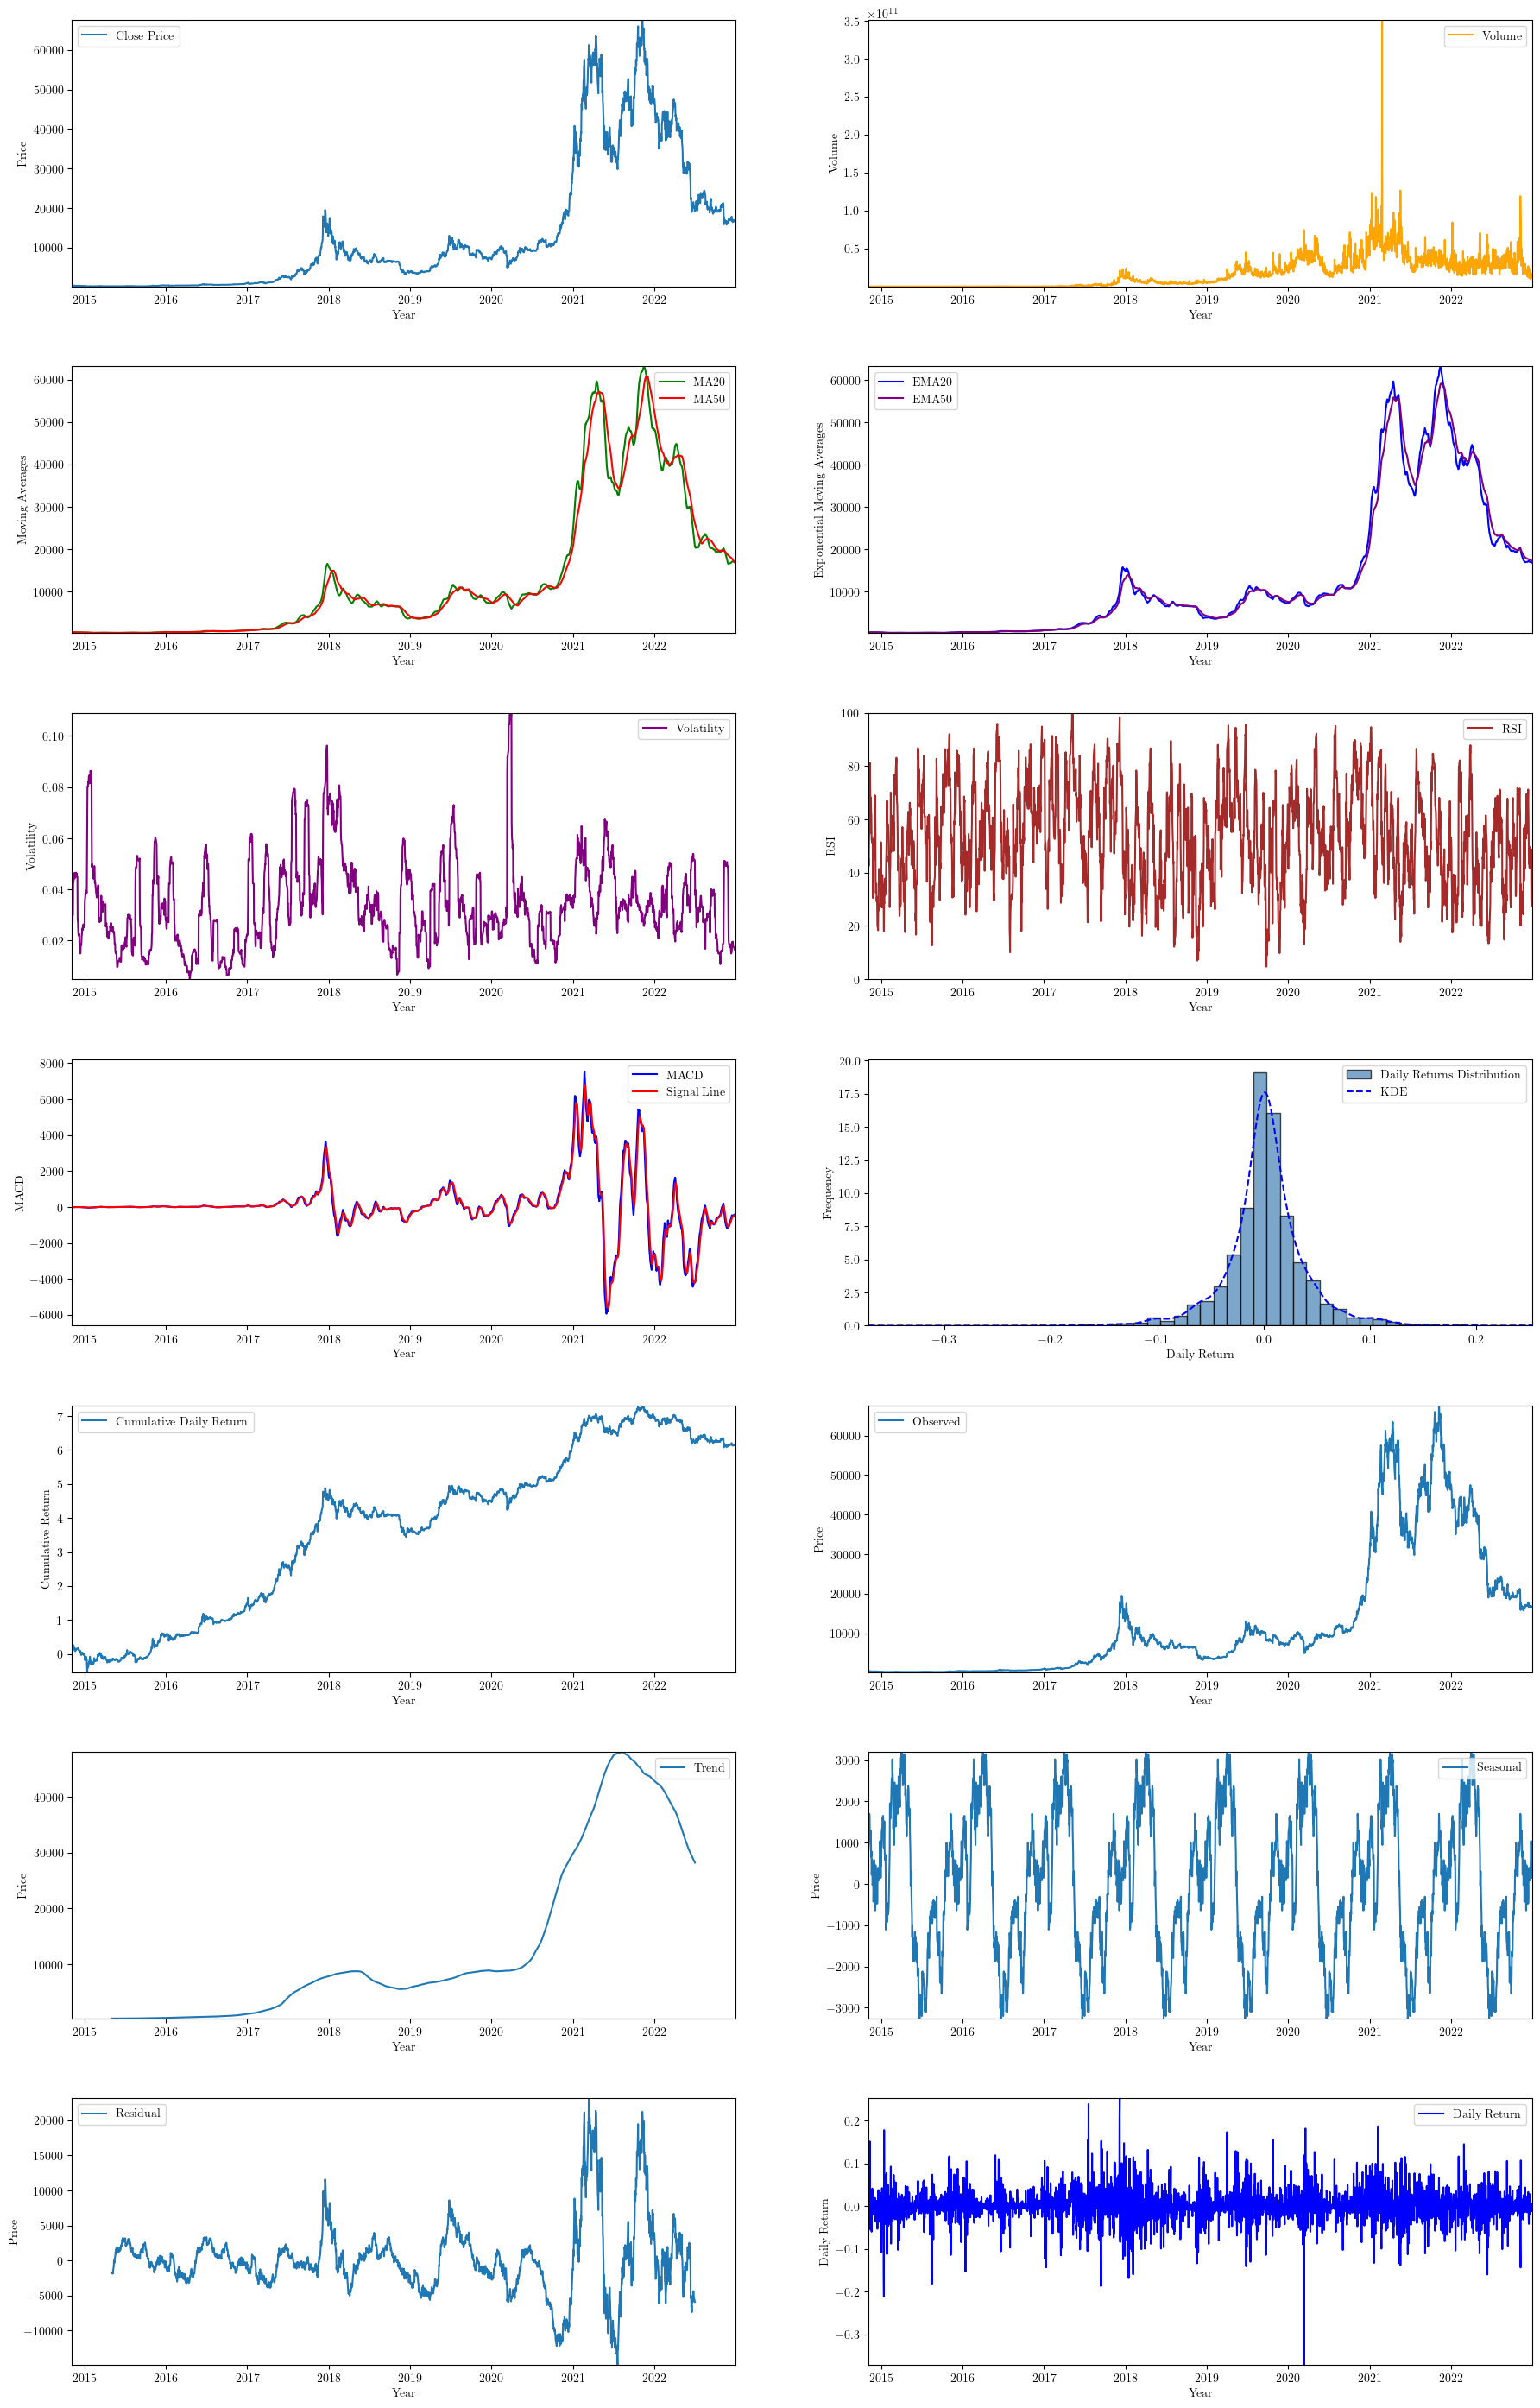

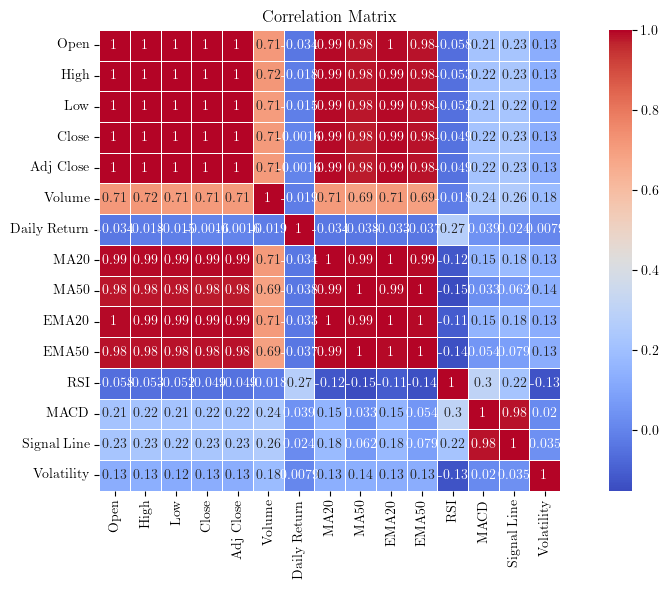

In [29]:
# Perform EDA for each asset
for asset, df in data.items():
  perform_eda(asset, df)

# Insights

- TSLA and BTC-USD:
    - High Volatility: TSLA and Bitcoin (BTC-USD) stand out for their high volatility. TSLA shows frequent price spikes, while Bitcoin exhibits extreme price fluctuations and intense trading activity.
    - Investment Implications: These assets are suited for high-risk, high-reward strategies. Investors must use advanced volatility models (e.g., GARCH) and robust outlier detection methods to manage risk.

- AAPL, MSFT, GOOGL, AMZN, SPY:
    - Moderate Volatility: These assets show stable price movements with fewer extreme outliers, making them suitable for more conservative investment strategies. Standard deviation and ARIMA models are adequate for predicting trends and managing risks.
    - Market Response: Occasional high-volume days indicate responsiveness to market news and events, which can be analyzed using event study methodologies.

- GLD:
    - Stability: GLD’s low volatility and fewer outliers confirm its stability. Suitable for risk-averse investors, it can be effectively managed using coefficient of variation (CV) and liquidity measures.

The analysis underscores the varying risk-return profiles of different assets. Traditional stocks and ETFs offer stability and moderate returns, suitable for conservative strategies. In contrast, TSLA and Bitcoin require sophisticated risk management due to their high volatility. Understanding these dynamics helps in making informed financial decisions and optimizing portfolio performance.


# Trend Analysis
- **Overall Upward Trends**: Most assets exhibit an overall upward trend, reflecting growth and positive investor sentiment over time.
- **Periodic Dips**: All assets show periodic dips in their trends, often corresponding to broader market corrections or specific events affecting the asset.
    - Note: Gold prices experienced a significant decline during 2015-2016. Reason: federal reserve rate hike, recovering global economy
- **Volatility**:
    - High Volatility: BTC-USD and TSLA show the highest volatility in their trends, with sharp rises and falls.
    - Moderate Volatility: AAPL, MSFT, GOOGL, and AMZN exhibit moderate volatility with more stable upward trends.
    - Low Volatility: SPY and GLD have the most stable trends with gradual increases and fewer sharp fluctuations.
- **Growth Rate**:
    - Rapid Growth: TSLA and AMZN show rapid growth rates in their trends, reflecting aggressive market strategies.
    - Steady Growth: AAPL, MSFT, and GOOGL show steady and consistent growth, indicative of strong business fundamentals.
    - Stable Growth: SPY and GLD reflect stable, long-term growth aligned with market averages and safe-haven investment strategies.

# Feature Selection Based on Correlation Matrices

## Retained Features
1. **Close (or Adjusted Close)**: Represents the price level.
2. **Volume**: Captures trading activity and market sentiment.
3. **Daily Return**: Provides insights into price movement and risk.
4. **Volatility**: Measures the variability and risk of the asset’s returns.
5. **MA50**: Identifies long-term trends.
6. **RSI**: Indicates overbought or oversold conditions
7. **MACD**, **Signal Line**: Momentum indicators that add value

## Discarded Features
1. **Open**
2. **High**
3. **Low**
4. **Adjusted Close**
5. **MA20** 

## Rationale
- **Reduce Multicollinearity**: Discarding highly correlated features (Open, High, Low, and one moving average) reduces redundancy.
- **Retain Informative Features**: Keeping Volume, Daily Return, Volatility, and one moving average ensures access to critical information.

## Final Feature Set
- **target**: Close
- **features**: Volume, Daily Return, MA50, RSI, MACD, Signal Line, Volatility

# The full correlation matrix

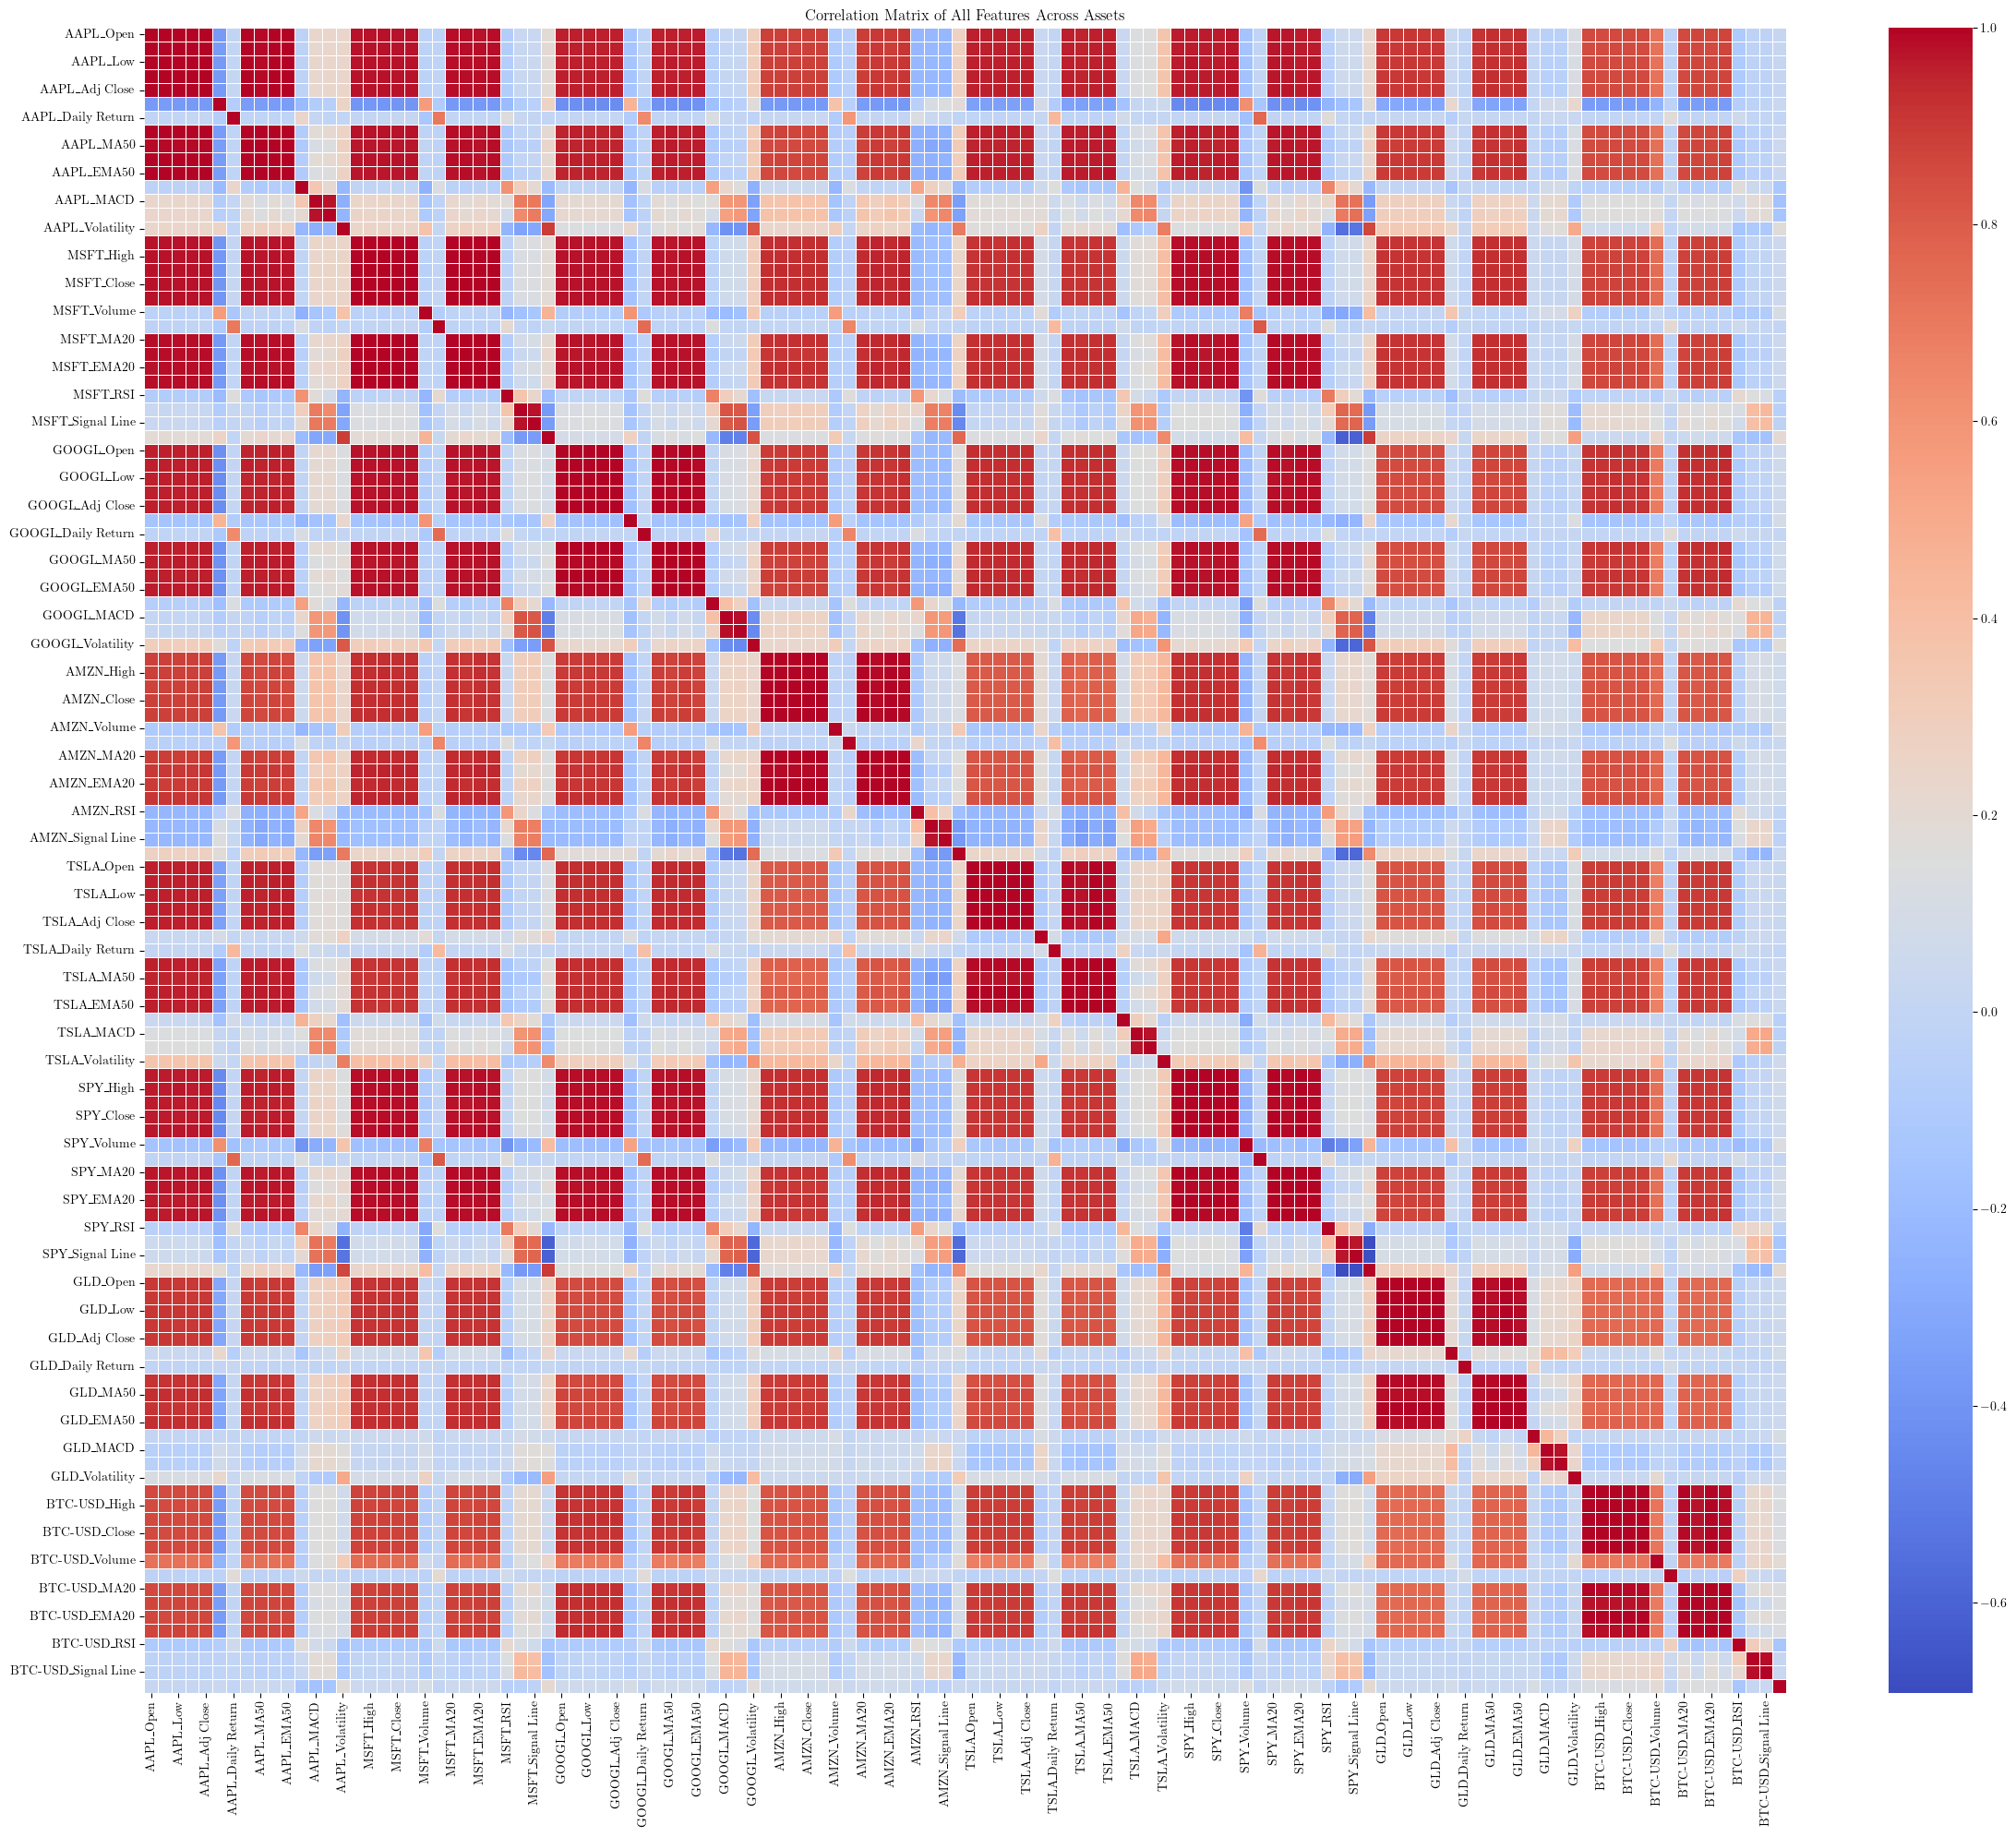

In [14]:
# List of assets
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'SPY', 'GLD', 'BTC-USD']

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()

for asset, df in data.items():
    # Prefix the columns with the asset name to avoid confusion
    df = df.add_prefix(f'{asset}_')
    
    # Merge the data
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.join(df, how='inner')

# Compute the correlation matrix
corr_matrix = merged_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of All Features Across Assets')
plt.tight_layout()

# Show the plot
plt.show()


# Histogram plot analysis

In [15]:
# Function to perform EDA for a given asset
def hist_analysis(asset, df):
    # Calculating necessary quantities for comparison
    avg_daily_return = df['Daily Return'].mean()
    std_daily_return = df['Daily Return'].std()
    avg_volatility = df['Volatility'].mean()
    std_volatility = df['Volatility'].std()
    
    # print(f'Average Daily Return for {asset}: {avg_daily_return:.4f}')
    # print(f'Standard Deviation of Daily Return for {asset}: {std_daily_return:.4f}')
    # print(f'Average Volatility for {asset}: {avg_volatility:.4f}')
    # print(f'Average Volume for {asset}: {avg_volume:.4f}')
    
    return avg_daily_return, std_daily_return, avg_volatility, std_volatility


     Asset  Avg Daily Return  Std Daily Return  Avg Volatility  Std Volatility
0     AAPL          0.001079          0.018083        0.016557        0.007340
1     MSFT          0.000869          0.016425        0.014865        0.007286
2    GOOGL          0.000714          0.017055        0.015570        0.007133
3     AMZN          0.001008          0.020839        0.019137        0.008427
4     TSLA          0.002087          0.035754        0.032840        0.013664
5      SPY          0.000511          0.011116        0.009386        0.006062
6      GLD          0.000188          0.009854        0.009185        0.003616
7  BTC-USD          0.002058          0.038381        0.034376        0.016896


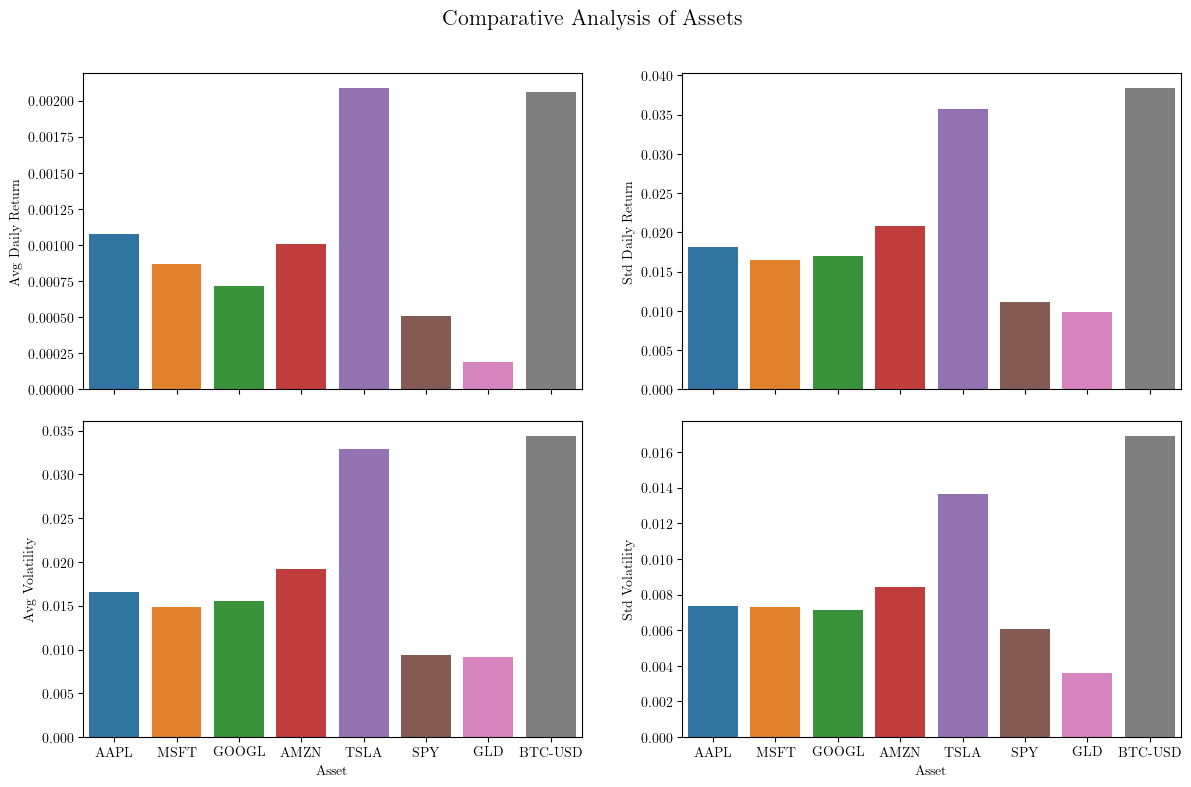

In [16]:
# Dictionary to store comparative analysis results
comparative_analysis = {
    'Asset': [],
    'Avg Daily Return': [],
    'Std Daily Return': [],
    'Avg Volatility': [],
    'Std Volatility': []
}

# Perform EDA for each asset and gather results
for asset, df in data.items():
    avg_daily_return, std_daily_return, avg_volatility, std_volatility = hist_analysis(asset, df)
    comparative_analysis['Asset'].append(asset)
    comparative_analysis['Avg Daily Return'].append(avg_daily_return)
    comparative_analysis['Std Daily Return'].append(std_daily_return)
    comparative_analysis['Avg Volatility'].append(avg_volatility)
    comparative_analysis['Std Volatility'].append(std_volatility)

# Create a DataFrame for comparative analysis
comparative_df = pd.DataFrame(comparative_analysis)
print(comparative_df)

# Plotting comparative analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparative Analysis of Assets', fontsize=16)

# Custom color palette
palette = sns.color_palette("viridis", len(comparative_df))
palette = {
    'AAPL': '#1f77b4',
    'MSFT': '#ff7f0e',
    'GOOGL': '#2ca02c',
    'AMZN': '#d62728',
    'TSLA': '#9467bd',
    'SPY': '#8c564b',
    'GLD': '#e377c2',
    'BTC-USD': '#7f7f7f'
}

# Average Daily Return
sns.barplot(x='Asset', y='Avg Daily Return', hue='Asset', data=comparative_df, ax=axes[0, 0], palette=palette, dodge=False, legend=False)
# axes[0, 0].set_title('Average Daily Return')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Avg Daily Return')
axes[0, 0].set_xticklabels('')

# Standard Deviation of Daily Return
sns.barplot(x='Asset', y='Std Daily Return', hue='Asset', data=comparative_df, ax=axes[0, 1], palette=palette, dodge=False, legend=False)
# axes[0, 1].set_title('Standard Deviation of Daily Return')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Std Daily Return')
axes[0, 1].set_xticklabels('')

# Average Volatility
sns.barplot(x='Asset', y='Avg Volatility', hue='Asset', data=comparative_df, ax=axes[1, 0], palette=palette, dodge=False, legend=False)
# axes[1, 0].set_title('Average Volatility')
axes[1, 0].set_xlabel('Asset')
axes[1, 0].set_ylabel('Avg Volatility')

# Standard Deviation of Volatility
sns.barplot(x='Asset', y='Std Volatility', hue='Asset', data=comparative_df, ax=axes[1, 1], palette=palette, dodge=False, legend=False)
# axes[1, 1].set_title('Standard Deviation of Volatility')
axes[1, 1].set_xlabel('Asset')
axes[1, 1].set_ylabel('Std Volatility')
# axes[1, 1].set_ylim(0, 3.002502e+08)

'''
# Define the inset axes
inset_ax = inset_axes(axes[1, 1], width="80%", height="80%", bbox_to_anchor=(0.00, 0.1, 0.8, 0.8), bbox_transform=axes[1, 1].transAxes)

# Plot the barplot in the inset
sns.barplot(x='Asset', y='Std Volatility', hue='Asset', data=comparative_df, ax=inset_ax, palette=palette, dodge=False, legend=False)
# inset_ax.set_ylim(0, 3.0e+08)

# Optionally remove the x and y labels in the inset
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')
inset_ax.set_xticklabels('')
'''

fig.subplots_adjust(left=0.075,
                    bottom=0.07, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.1)

plt.show()
fig.savefig (f'../plots/comparison_between_assets.pdf')


### 1. Average Daily Return    
- Highest Returns: BTC-USD (Bitcoin) shows the highest average daily return, indicating its high growth potential and aggressive nature.
- Other Notable Performers: TSLA also demonstrates a significant average daily return.
- Stable Performers: Traditional stocks like AAPL, MSFT, and SPY have lower average daily returns, reflecting their stable and less volatile nature compared to Bitcoin and Tesla.

### 2. Standard Deviation of Daily Return
- High Volatility: BTC-USD and TSLA exhibit the highest standard deviation of daily returns, consistent with their high average daily returns.
- Moderate Volatility: GOOGL and AMZN show moderate volatility.
- Low Volatility: AAPL, MSFT, SPY, and GLD show lower standard deviations, indicating more predictable performance.

### 3. Average Volatility
- High Volatility: BTC-USD and TSLA again lead, confirming their high-risk, high-reward profiles.
- Moderate Volatility: AMZN and GOOGL are moderately volatile.
- Low Volatility: SPY, GLD, AAPL, and MSFT remain less volatile, indicating safer investment choices.

### 4. Standard Deviation of Volatility
- High Variability in Volatility: BTC-USD has the highest standard deviation of volatility, reflecting its unpredictable nature.
- Moderate Variability: TSLA and AMZN show significant variability.
- Low Variability: Traditional assets like AAPL, MSFT, SPY, and GLD show lower variability in volatility, suggesting more stable investment behavior.
  
### Conclusion
- Risk and Return Trade-off: BTC-USD and TSLA offer higher potential returns but come with significant risks, reflected in their high average returns and high volatility metrics. These assets are suitable for risk-tolerant investors seeking high growth.
- Tech Stocks: AAPL, MSFT, GOOGL, and AMZN show moderate returns and volatility. These could be considered balanced options, offering growth potential without the extreme volatility of TSLA or BTC-USD.
- Stability and Predictability: Assets like AAPL, MSFT, SPY, and GLD provide lower but more stable returns, making them suitable for risk-averse investors seeking predictable performance.
- Diversification: Incorporating a mix of high and low volatility assets can balance a portfolio, mitigating risks while capturing growth opportunities.


# Box plot analysis

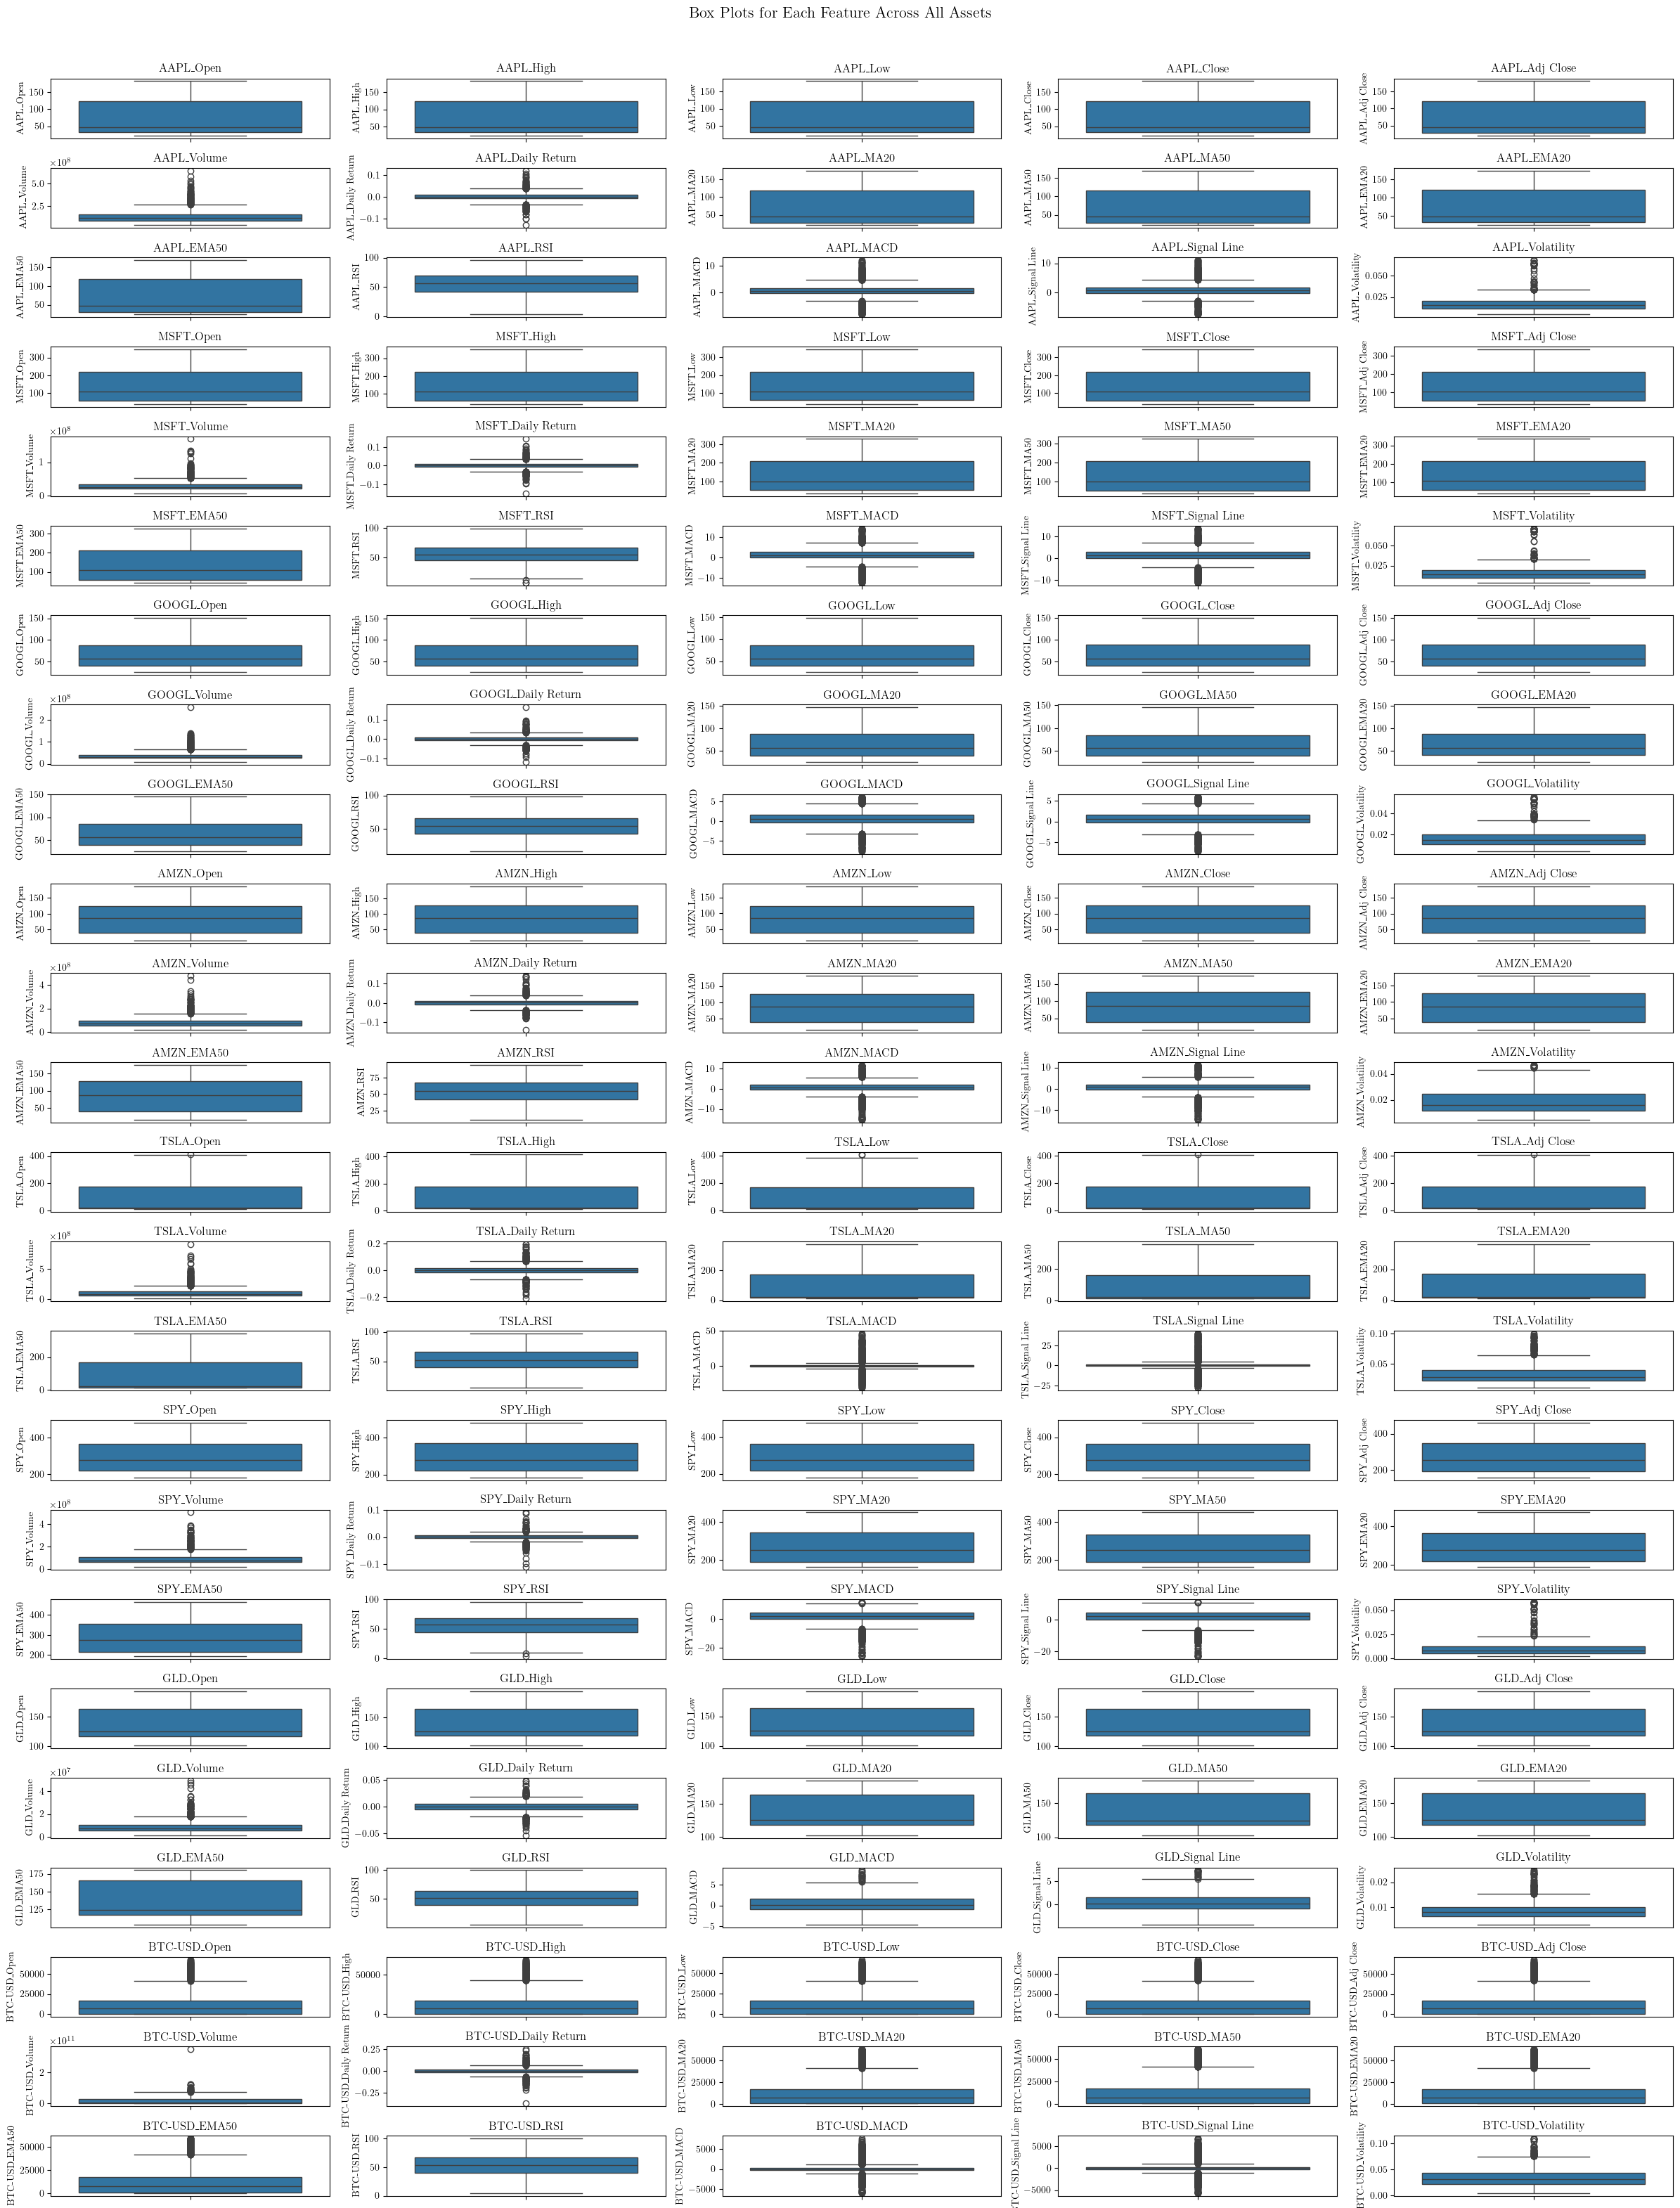

In [17]:
# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()

for asset, df in data.items():    
    # Prefix the columns with the asset name to avoid confusion
    df = df.add_prefix(f'{asset}_')
    
    # Merge the data
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.join(df, how='inner')

# Plotting box plots for each feature
plt.figure(figsize=(24, 32))

# Create subplots for each feature
num_features = merged_df.shape[1]
num_plots_per_row = 5
num_rows = (num_features // num_plots_per_row) + (num_features % num_plots_per_row > 0)

for i, column in enumerate(merged_df.columns, 1):
    plt.subplot(num_rows, num_plots_per_row, i)
    sns.boxplot(y=merged_df[column])
    plt.title(column)
    plt.tight_layout()

plt.suptitle('Box Plots for Each Feature Across All Assets', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'../plots/boxplots.pdf')
plt.show()

### Summary

- AAPL, MSFT, GOOGL, AMZN, TSLA:
    - Consistency: These stocks generally show a more consistent price range with fewer extreme outliers compared to Bitcoin.
    - Volatility: Stocks like TSLA are more volatile compared to others like AAPL and MSFT, but none are as volatile as Bitcoin.
    - Trading Volume: High-volume outliers are present in all stocks, indicating days of significant trading activity, often linked to market events or company news.

- ETF (SPY):
    - Stability: SPY exhibits more stability and fewer outliers due to its diversified nature, making it less volatile than individual stocks.
    - Market Impact: It still shows high-volume trading days, reflecting broader market movements.

- Gold (GLD):
    - Stability: GLD shows a stable price range with fewer outliers, highlighting its nature as a relatively safe investment.
    - Volatility: It is less volatile than both stocks and Bitcoin.

- Bitcoin (BTC-USD):
    - Extreme Volatility: Bitcoin shows the highest volatility and the widest price range with significant outliers.
    - Trading Activity: Exhibits intense trading activity and significant daily price fluctuations.

### Conclusion
- Similarity Among Stocks: Most traditional stocks and ETFs show relatively similar behavior with consistent price ranges and occasional high-volume trading days.
- Unique Behavior of Bitcoin: Bitcoin stands out with its extreme volatility and frequent outliers, distinguishing its behavior significantly from that of traditional stocks and ETFs.

Thus, while traditional stocks and ETFs share some behavioral similarities, Bitcoin exhibits a distinct and much more volatile pattern.

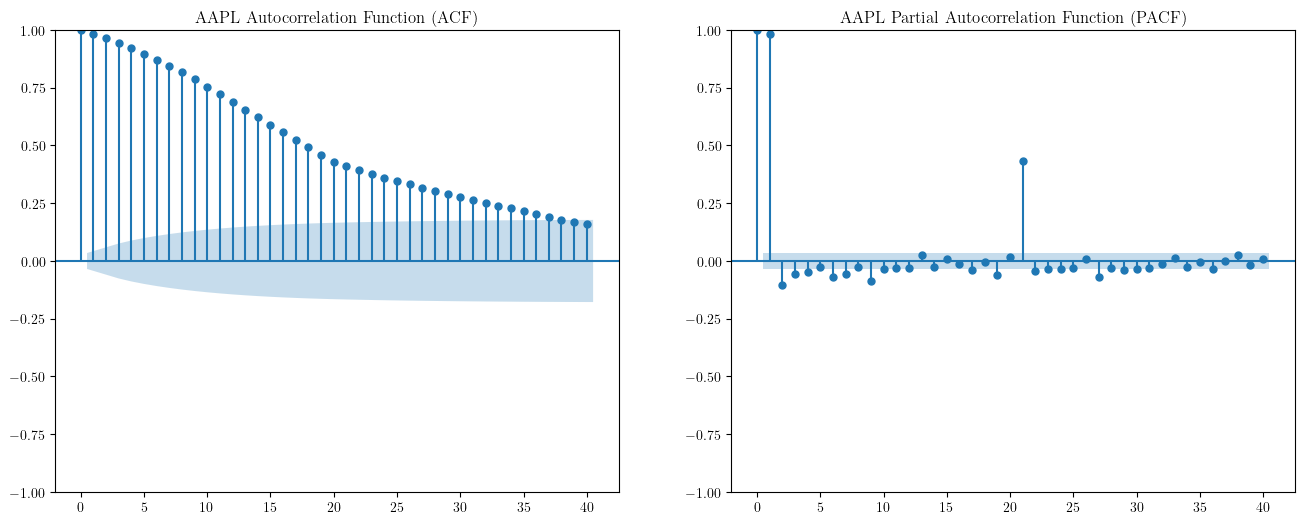

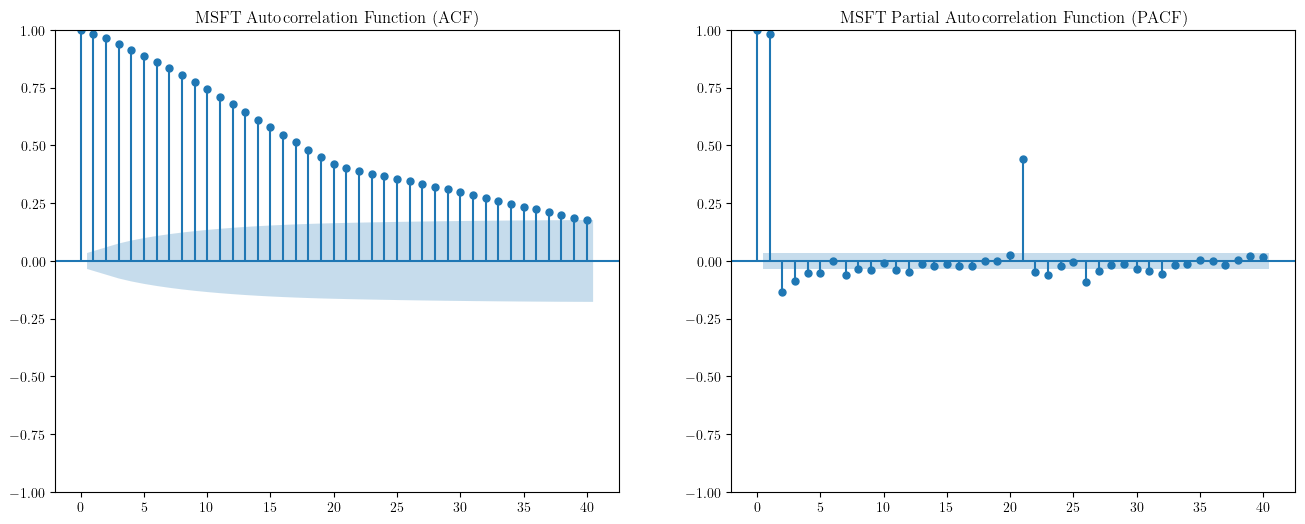

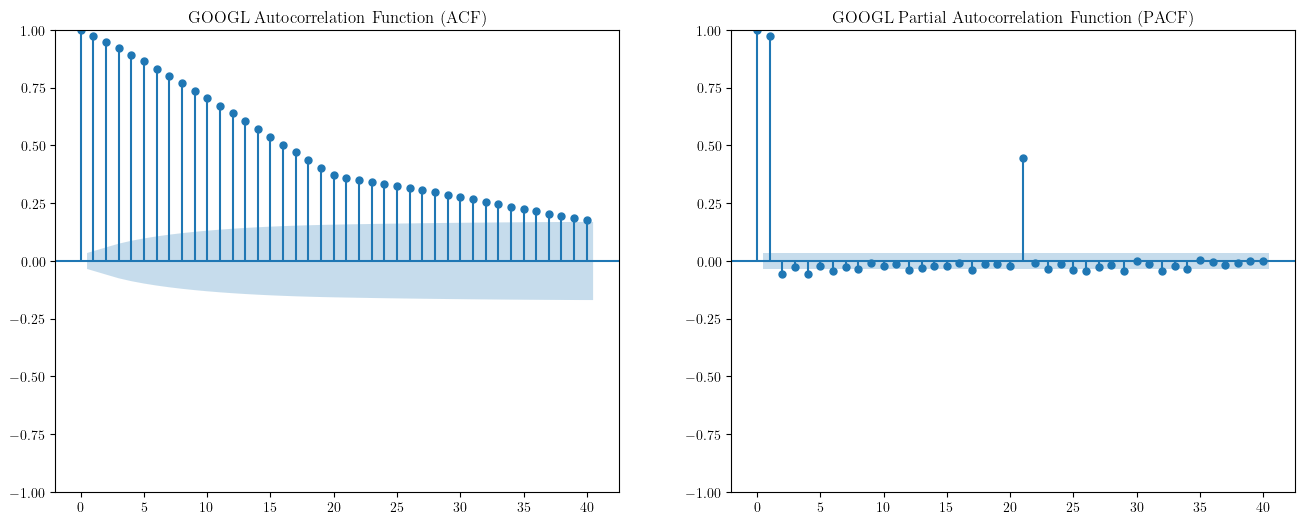

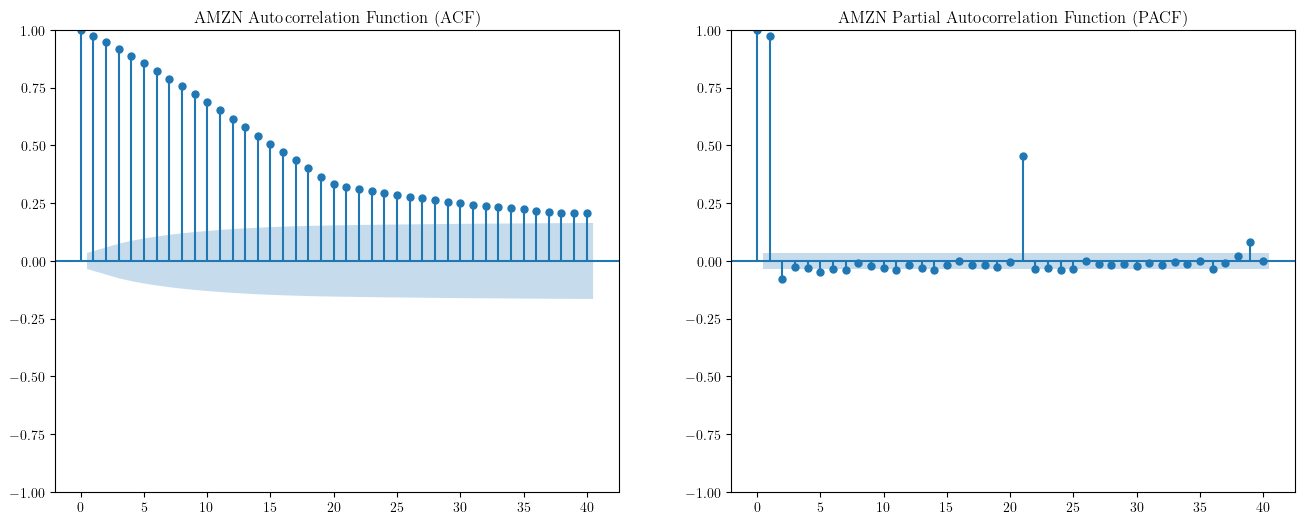

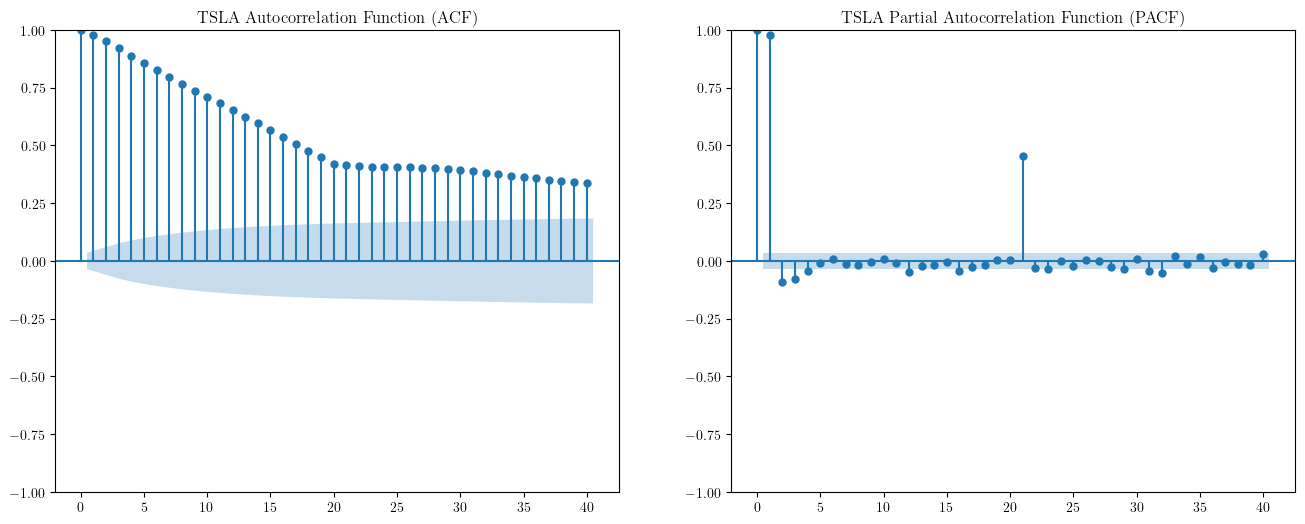

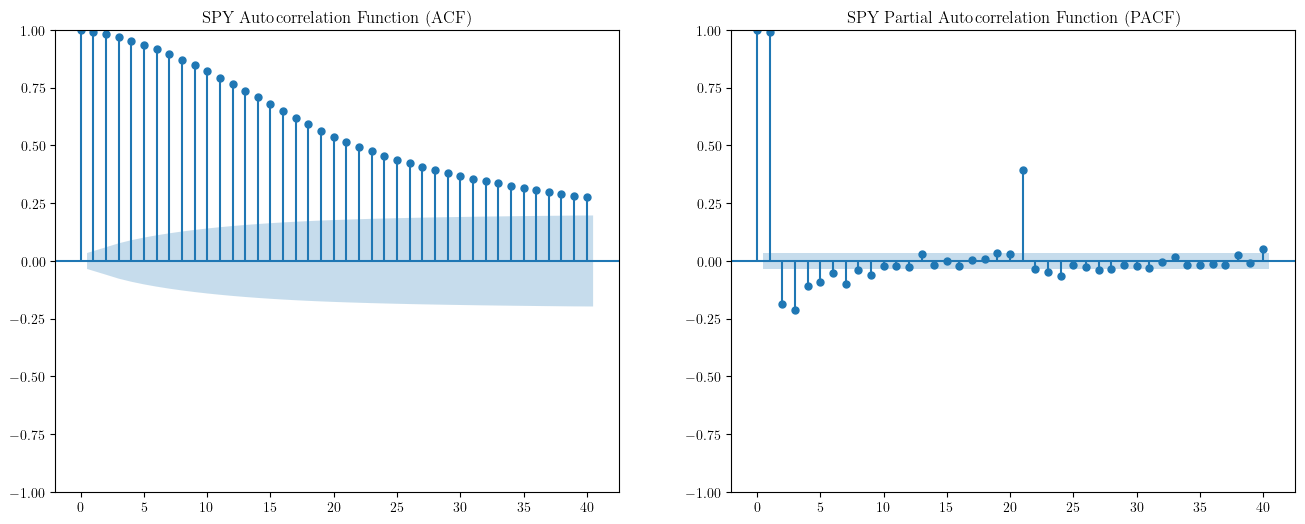

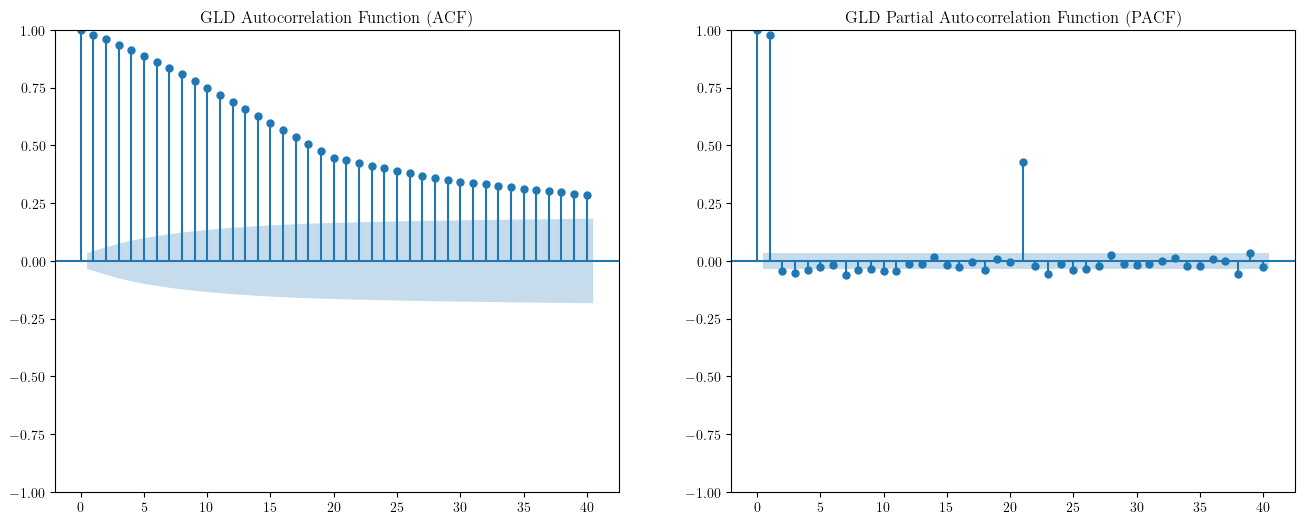

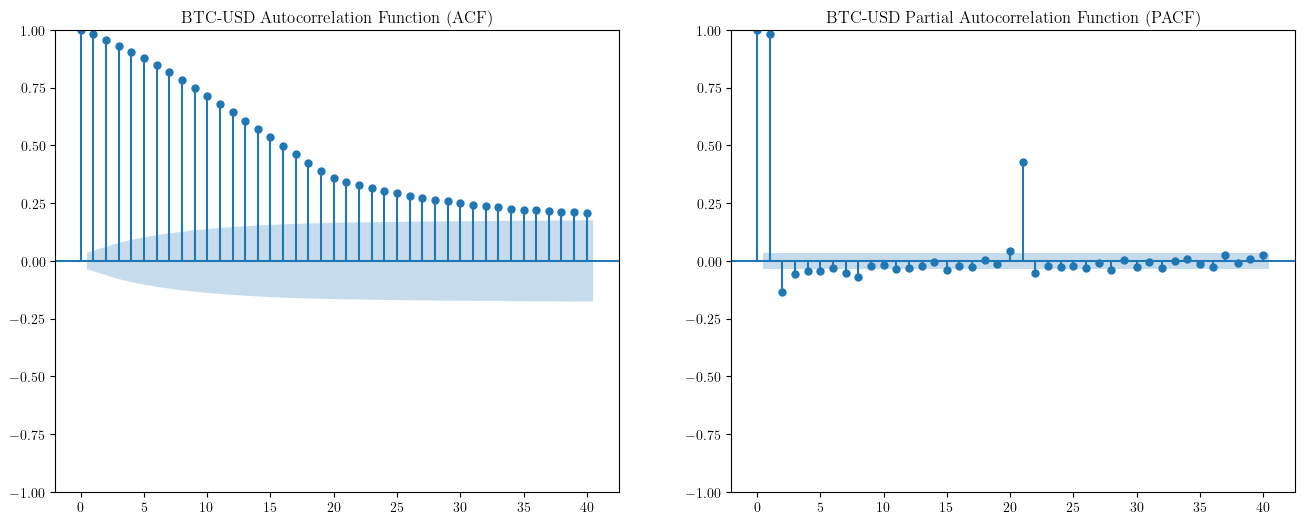

In [18]:
for asset, df in data.items():
    
    # Select the column for analysis (e.g., 'Close' or 'Daily Return')
    series = df['Volatility']
    
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    plot_acf(series, ax=axes[0], lags=40)
    plot_pacf(series, ax=axes[1], lags=40)
    
    axes[0].set_title(f'{asset} Autocorrelation Function (ACF)')
    axes[1].set_title(f'{asset} Partial Autocorrelation Function (PACF)')
    
    plt.show()